# **P2 Analysez des données de systèmes éducatifs**

## **1/ Introduction**

Academy est une start-up de la EdTech qui propose des contenus de formation en ligne pour un public de niveau lycée et université. 
Dans le cadre du projet d'extention à l''international de l'entreprise, une analyse pré exploratoire est nessecaire. Parmi les données fournies par la banque mondiale, déterminons quels pays disposent du plus fort potentiel client et tentons de suivre l'évolution de leur potentiel clients pour chaque pays.

Sources : https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/Parcours_data_scientist/Projet+-+Donn%C3%A9es+%C3%A9ducatives/Projet+Python_Dataset_Edstats_csv.zip

Plusieurs étapes devront être respecter dans la réalisation de ce projet. 
- Nettoyer les différents jeux de données
- Conserver les variables les plus pertinentes dans un DataFrame
- Analyser ce DataFrame et produire une évolution dans le temps

In [172]:
import pandas as pd
pd.set_option('display.max_columns', 100)
import numpy as np
import re
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

## **2/ Description des jeux de données**

### *2-1/EdStatsCountry*

Dans un premier temps commençons par charger notre première base de données. Essayons aussi de l'afficher afin de constater qu'il n'y ait aucun problèmes

In [177]:
# Chargement + affichage de la base de données
data = pd.read_csv('EdStatsCountry.csv')
data.head(1)

,Country Code,Short Name,Table Name,Long Name,2-alpha code,Currency Unit,Special Notes,Region,Income Group,WB-2 code,National accounts base year,National accounts reference year,SNA price valuation,Lending category,Other groups,System of National Accounts,Alternative conversion factor,PPP survey year,Balance of Payments Manual in use,External debt Reporting status,System of trade,Government Accounting concept,IMF data dissemination standard,Latest population census,Latest household survey,Source of most recent Income and expenditure data,Vital registration complete,Latest agricultural census,Latest industrial data,Latest trade data,Latest water withdrawal data,Unnamed: 31
0,ABW,Aruba,Aruba,Aruba,AW,Aruban florin,SNA data for 2000-2011 are updated from official government statistics; 1994-1999 from UN databases. Base year has changed from 1995 to 2000.,Latin America & Caribbean,High income: nonOECD,AW,2000,NaN,Value added at basic prices (VAB),NaN,NaN,Country uses the 1993 System of National Accounts methodology.,NaN,NaN,"IMF Balance of Payments Manual, 6th edition.",NaN,Special trade system,NaN,NaN,2010,NaN,NaN,Yes,NaN,NaN,2012.0,NaN,NaN


Aucun problème à detecter pour le moment. Interessons nous maintenant au nombres de lignes et de colonnes présent dans le fichier :

In [218]:
# Affiche le nombre de lignes et de colonnes
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241 entries, 0 to 240
Data columns (total 32 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Country Code                                       241 non-null    object 
 1   Short Name                                         241 non-null    object 
 2   Table Name                                         241 non-null    object 
 3   Long Name                                          241 non-null    object 
 4   2-alpha code                                       238 non-null    object 
 5   Currency Unit                                      215 non-null    object 
 6   Special Notes                                      145 non-null    object 
 7   Region                                             214 non-null    object 
 8   Income Group                                       214 non-null    object 
 9   WB-2 code 

Le fichier possède 241 lignes et 32 colonnes. 4 colonnes sont des float, le reste sont des object.

Maintenant que les bases sont posés, essayons de commencer notre travail préparatoire. Dans un premier temps nous allons vérifier si le fichier contient des données manquantes :

In [222]:
# Recherche de données manquantes :
pd.DataFrame(data.isnull().sum(axis=0)).transpose()

,Country Code,Short Name,Table Name,Long Name,2-alpha code,Currency Unit,Special Notes,Region,Income Group,WB-2 code,National accounts base year,National accounts reference year,SNA price valuation,Lending category,Other groups,System of National Accounts,Alternative conversion factor,PPP survey year,Balance of Payments Manual in use,External debt Reporting status,System of trade,Government Accounting concept,IMF data dissemination standard,Latest population census,Latest household survey,Source of most recent Income and expenditure data,Vital registration complete,Latest agricultural census,Latest industrial data,Latest trade data,Latest water withdrawal data,Unnamed: 31
0,0,0,0,0,3,26,96,27,27,1,36,209,44,97,183,26,194,96,60,117,41,80,60,28,100,81,130,99,134,56,62,241


La réponse est donc oui. De nombreuses colonnes présentes des lignes vides.
Soyons plus précis maintenant et retirons les colonnes où il n'y a aucun problème :

In [225]:
# Supprime les colonnes sans données manquantes
nb_na = data.isnull().sum()
nb_na[nb_na>0]

2-alpha code                                           3
Currency Unit                                         26
Special Notes                                         96
Region                                                27
Income Group                                          27
WB-2 code                                              1
National accounts base year                           36
National accounts reference year                     209
SNA price valuation                                   44
Lending category                                      97
Other groups                                         183
System of National Accounts                           26
Alternative conversion factor                        194
PPP survey year                                       96
Balance of Payments Manual in use                     60
External debt Reporting status                       117
System of trade                                       41
Government Accounting concept  

Cherchons maintenant à savoir si notre fichier contient ou non des doublons :

In [228]:
# Recherche de doublons
data.duplicated().sum()

0

Selon toute vraisemblance, non. 
Dans ce fichier occupons nous des valeurs manquantes. Cependant la plupart des colonnes ne sont pas pertinentes dans notre analyse de données. Concentrons nos effort sur 3 colonnes : "Long Name", "Region" et "Income Group". 

In [231]:
# Recherche de ligne identiques en prenant en compte nos paramètres
doublon_data = data[data.duplicated(['Long Name','Region','Income Group'], keep=False)].shape[0];
doublon_data

0

Créons un dataframe réunissant ces 3 données :

In [234]:
# Création d'un dataframe
data_frame = data[['Long Name', 'Region', 'Income Group']]

Déterminons le nombre de pays par région puis par par groupe de revenu :

In [237]:
# On compte le nombre de pays par région
region_distribution = data_frame['Region'].value_counts()
# On compte le nombre de pays par groupe de revenu
income_group_distribution = data_frame['Income Group'].value_counts()

Créeons ensuite une série pandas qui contient, pour chaque groupe d'Income Group, le nombre total de lignes présentes dans chaque groupe.

In [240]:
# Regroupe data_frame par la colonne 'Region' et compte le nombre de lignes pour chaque région.
stats_by_region = data_frame.groupby('Region').size()
# Regroupe data_frame par la colonne 'Income Group' et compte le nombre de lignes pour chaque groupe de revenu.
stats_by_income_group = data_frame.groupby('Income Group').size()

Maintenant que nous avons tous ce qu'il nous faut à disposition, construisons un graphique afin de mettre en corrélation les variables que l'ont souhaite garder. Représentons graphiquement dans un premier temps le nombre de pays par région puis le nombre de pays par groupe de revenu :

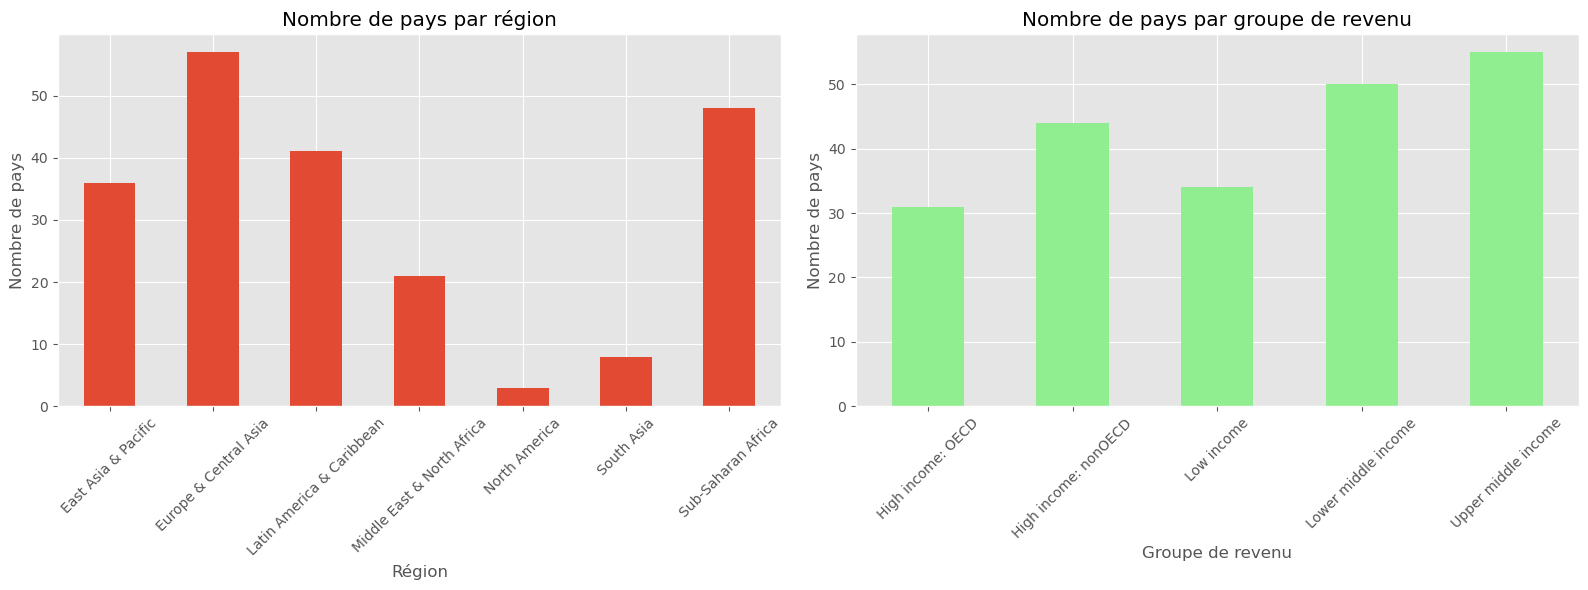

In [243]:
# Création d'une figure avec deux sous-graphiques côte à côte
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Graphique du nombre de pays par région
stats_by_region.plot(kind='bar', ax=axes[0])
axes[0].set_title('Nombre de pays par région')
axes[0].set_ylabel('Nombre de pays')
axes[0].set_xlabel('Région')
axes[0].tick_params(axis='x', rotation=45)

# Graphique du nombre de pays par groupe de revenu
stats_by_income_group.plot(kind='bar', ax=axes[1], color='lightgreen')
axes[1].set_title('Nombre de pays par groupe de revenu')
axes[1].set_ylabel('Nombre de pays')
axes[1].set_xlabel('Groupe de revenu')
axes[1].tick_params(axis='x', rotation=45)

# Ajustement de l'espacement
plt.tight_layout()
plt.show()

Le bilan de ce premier fichier :
- Il contient 241 lignes et 32 colonnes
- De nombreuses données manquantes dans notre fichier
- Aucun doublon
- Pour répondre à notre problématique 3 variables sortent du lots : "Long Name", "Region" et "High Income"
- Unnamed: 31 est vide

### *2-2EdStatsCountry-Series*

In [246]:
# Chargement + affichage de la base de données
data2 = pd.read_csv('EdStatsCountry-Series.csv')
data2.head(1)

,CountryCode,SeriesCode,DESCRIPTION,Unnamed: 3
0,ABW,SP.POP.TOTL,Data sources : United Nations World Population Prospects,NaN


In [247]:
# Affiche le nombre de lignes et de colonnes
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 613 entries, 0 to 612
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   CountryCode  613 non-null    object 
 1   SeriesCode   613 non-null    object 
 2   DESCRIPTION  613 non-null    object 
 3   Unnamed: 3   0 non-null      float64
dtypes: float64(1), object(3)
memory usage: 19.3+ KB


Notre fichier possède 613 lignes pour 4 colonnes. 

In [250]:
# Recherche de données manquantes :
pd.DataFrame(data2.isnull().sum()).transpose()

,CountryCode,SeriesCode,DESCRIPTION,Unnamed: 3
0,0,0,0,613


Aucune données manquantes pour nos 3 premières colonnes. Unnamed: 3 semble vide

In [254]:
# Recherche de doublons
data2.duplicated().sum()

0

In [256]:
# Recherche de ligne identiques en prenant en compte tous nos paramètres
doublon_data2 = data2[data2.duplicated(['CountryCode','SeriesCode','DESCRIPTION'], keep=False)].shape[0];
doublon_data2

0

Aucun doublon à signaler quand on vérifie sur les 3 colonnes à la fois.

In [260]:
# Recherche de doublons sur la colonne Unnamed: 3
doublon_Unnamed3 = data2[data2.duplicated(['Unnamed: 3'], keep=False)].shape[0];
doublon_Unnamed3

613

In [261]:
# On compte le nombre de pays par 'SeriesCode'
SeriesCode_distribution = data2['SeriesCode'].value_counts()
# On compte le nombre de pays par 'DESCRIPTION'
DESCRIPTION_distribution = data2['DESCRIPTION'].value_counts()
# Regroupe data2 par la colonne 'SeriesCode' et compte le nombre de lignes pour chaque SeriesCode.
stats_by_SeriesCode = data2.groupby('SeriesCode').size()
# Regroupe data2 par la colonne 'DESCRIPTION' et compte le nombre de lignes pour chaque Description.
stats_by_DESCRIPTION = data2.groupby('DESCRIPTION').size()

Dans un premier temps on calcule le nombre de fois que chaque valeur unique apparaît dans la colonne correspondante.
Puis on calcule le nombre de lignes pour chaque groupe.

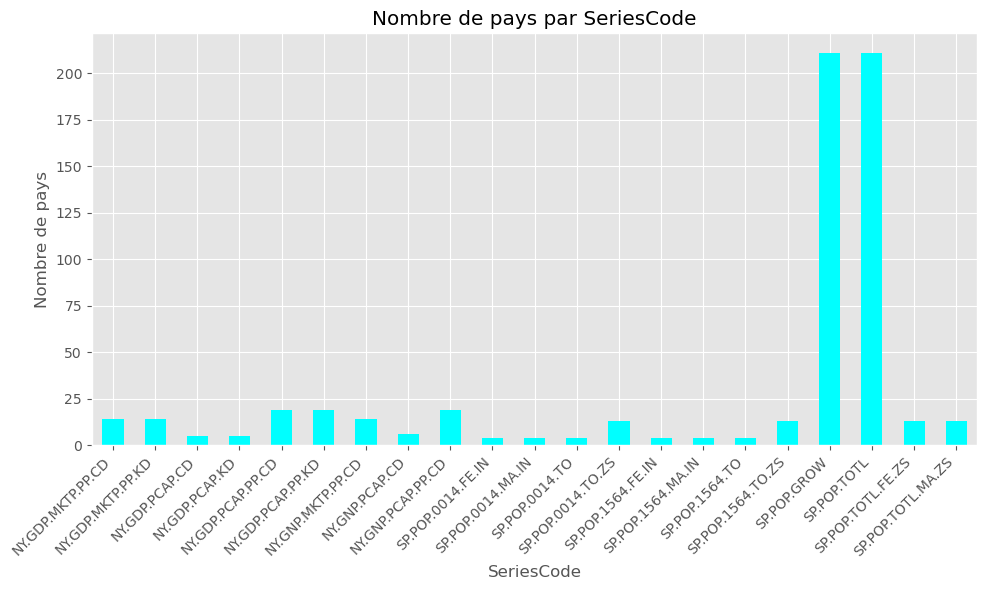

In [265]:
# Graphique du nombre de pays par SeriesCode
plt.figure(figsize=(10,6))
stats_by_SeriesCode.plot(kind='bar', color='cyan')
plt.title('Nombre de pays par SeriesCode')
plt.ylabel('Nombre de pays')
plt.xlabel('SeriesCode')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [266]:
# Identifier les 5 descriptions qui couvrent le plus grand nombre de pays 
nombre_pays_par_description_unique = data2.groupby('DESCRIPTION')['CountryCode'].nunique().sort_values(ascending=False).head(5)

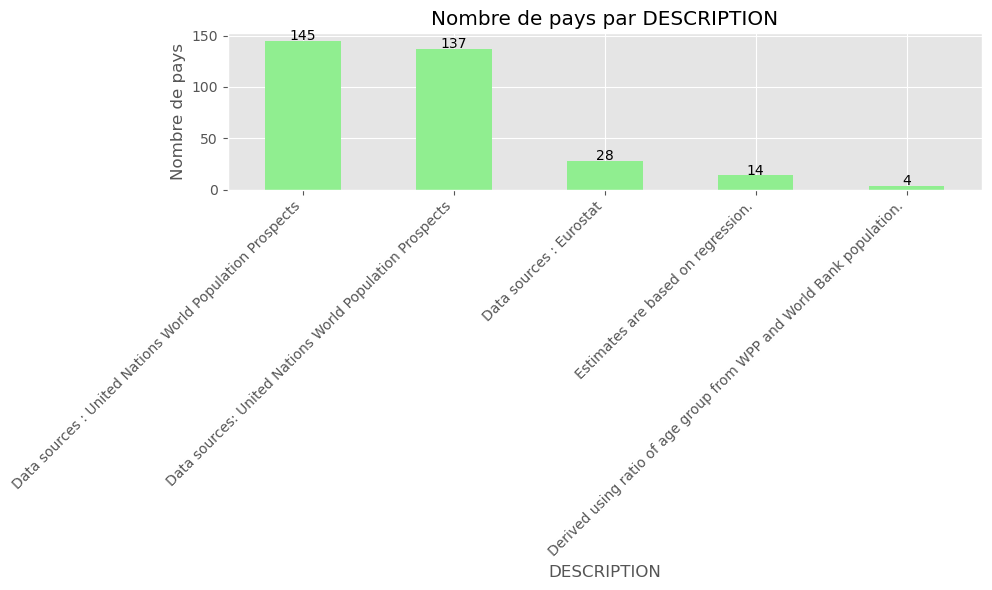

In [267]:
# Graphique du nombre de pays par DESCRIPTION
plt.figure(figsize=(10,6))
ax= nombre_pays_par_description_unique.plot(kind='bar', color='lightgreen')
plt.title('Nombre de pays par DESCRIPTION')
plt.ylabel('Nombre de pays')
plt.xlabel('DESCRIPTION')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
for index, value in enumerate(nombre_pays_par_description_unique):
    ax.text(index, value + 0.5, str(value), ha='center')
plt.show()

Le bilan de ce fichier :
- Le fichier dispose de 613 ligne et 4 colonnes
- Pas de données manquantes sauf pour la variable Unnamed: 3
- Pas de doublons sauf pour la variable unnamed: 3

### *2-3 EdStatsData*

In [179]:
# Chargement + affichage de la base de données
data3 = pd.read_csv('EdStatsData.csv')
data3.head(1)

,Country Name,Country Code,Indicator Name,Indicator Code,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2020,2025,2030,2035,2040,2045,2050,2055,2060,2065,2070,2075,2080,2085,2090,2095,2100,Unnamed: 69
0,Arab World,ARB,"Adjusted net enrolment rate, lower secondary, both sexes (%)",UIS.NERA.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [271]:
# Affiche le nombre de lignes et de colonnes
data3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 886930 entries, 0 to 886929
Data columns (total 70 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Country Name    886930 non-null  object 
 1   Country Code    886930 non-null  object 
 2   Indicator Name  886930 non-null  object 
 3   Indicator Code  886930 non-null  object 
 4   1970            72288 non-null   float64
 5   1971            35537 non-null   float64
 6   1972            35619 non-null   float64
 7   1973            35545 non-null   float64
 8   1974            35730 non-null   float64
 9   1975            87306 non-null   float64
 10  1976            37483 non-null   float64
 11  1977            37574 non-null   float64
 12  1978            37576 non-null   float64
 13  1979            36809 non-null   float64
 14  1980            89122 non-null   float64
 15  1981            38777 non-null   float64
 16  1982            37511 non-null   float64
 17  1983      

Pour ce fichier on dénombre 886930 lignes pour 70 colonnes

In [273]:
# Recherche de données manquantes :
pd.DataFrame(data3.isnull().sum()).transpose()

,Country Name,Country Code,Indicator Name,Indicator Code,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2020,2025,2030,2035,2040,2045,2050,2055,2060,2065,2070,2075,2080,2085,2090,2095,2100,Unnamed: 69
0,0,0,0,0,814642,851393,851311,851385,851200,799624,849447,849356,849354,850121,797808,848153,849419,848470,848324,796634,847558,848289,848378,849390,762525,812493,811387,811137,809468,755569,810123,813477,802016,768091,710254,763421,762725,756567,758116,702822,746618,749658,752543,744822,644488,740918,739666,749421,773141,755872,870470,886787,835494,835494,835494,835494,835494,835494,835494,835494,835494,835494,835494,835494,835494,835494,835494,835494,835494,886930


In [274]:
# Supprime les colonnes pleines
nb_na3 = data3.isnull().sum()
nb_na3[nb_na3>600000]

1970           814642
1971           851393
1972           851311
1973           851385
1974           851200
1975           799624
1976           849447
1977           849356
1978           849354
1979           850121
1980           797808
1981           848153
1982           849419
1983           848470
1984           848324
1985           796634
1986           847558
1987           848289
1988           848378
1989           849390
1990           762525
1991           812493
1992           811387
1993           811137
1994           809468
1995           755569
1996           810123
1997           813477
1998           802016
1999           768091
2000           710254
2001           763421
2002           762725
2003           756567
2004           758116
2005           702822
2006           746618
2007           749658
2008           752543
2009           744822
2010           644488
2011           740918
2012           739666
2013           749421
2014           773141
2015      

In [275]:
data3.duplicated().sum()

0

In [278]:
# Observons des données statistiques
data3.describe()

,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2020,2025,2030,2035,2040,2045,2050,2055,2060,2065,2070,2075,2080,2085,2090,2095,2100,Unnamed: 69
count,7.228800e+04,3.553700e+04,3.561900e+04,3.554500e+04,3.573000e+04,8.730600e+04,3.748300e+04,3.757400e+04,3.757600e+04,3.680900e+04,8.912200e+04,3.877700e+04,3.751100e+04,3.846000e+04,3.860600e+04,9.029600e+04,3.937200e+04,3.864100e+04,3.855200e+04,3.754000e+04,1.244050e+05,7.443700e+04,7.554300e+04,7.579300e+04,7.746200e+04,1.313610e+05,7.680700e+04,7.345300e+04,8.491400e+04,1.188390e+05,1.766760e+05,1.235090e+05,1.242050e+05,1.303630e+05,1.288140e+05,1.841080e+05,1.403120e+05,1.372720e+05,1.343870e+05,1.421080e+05,2.424420e+05,1.460120e+05,1.472640e+05,1.375090e+05,1.137890e+05,1.310580e+05,1.646000e+04,143.000000,5.143600e+04,5.143600e+04,5.143600e+04,5.143600e+04,5.143600e+04,5.143600e+04,5.143600e+04,5.143600e+04,5.143600e+04,5.143600e+04,5.143600e+04,5.143600e+04,5.143600e+04,5.143600e+04,5.143600e+04,5.143600e+04,5.143600e+04,0.0
mean,1.974772e+09,4.253638e+09,4.592365e+09,5.105006e+09,5.401493e+09,2.314288e+09,5.731808e+09,6.124437e+09,6.671489e+09,7.436724e+09,3.283898e+09,7.664969e+09,7.913722e+09,7.856908e+09,8.118002e+09,3.622763e+09,9.156550e+09,1.014901e+10,1.104709e+10,1.195436e+10,9.084424e+09,1.571674e+10,1.604668e+10,1.643532e+10,1.684022e+10,1.052543e+10,1.874630e+10,2.027385e+10,1.794678e+10,1.331558e+10,9.423384e+09,1.384867e+10,1.428299e+10,1.449393e+10,1.589729e+10,1.188637e+10,1.684674e+10,1.872300e+10,2.029794e+10,1.894907e+10,1.189592e+10,2.117911e+10,2.176323e+10,2.425332e+10,2.678449e+10,2.353720e+10,1.934411e+11,2.160839,5.780697e+02,6.054774e+02,6.315916e+02,6.556516e+02,6.751516e+02,6.911287e+02,7.040640e+02,7.145788e+02,7.224868e+02,7.271290e+02,7.283779e+02,7.266484e+02,7.228327e+02,7.176899e+02,7.113072e+02,7.034274e+02,6.940296e+02,NaN
std,1.211687e+11,1.804814e+11,1.914083e+11,2.059170e+11,2.112150e+11,1.375059e+11,2.215546e+11,2.325489e+11,2.473986e+11,2.660957e+11,1.780774e+11,2.744142e+11,2.790549e+11,2.823809e+11,2.940635e+11,2.002929e+11,3.264675e+11,3.535351e+11,3.804257e+11,4.014873e+11,3.665667e+11,4.881357e+11,5.012055e+11,5.121962e+11,5.292982e+11,4.285218e+11,5.812586e+11,6.142357e+11,5.859148e+11,5.153472e+11,4.442374e+11,5.449242e+11,5.622886e+11,5.803607e+11,6.278337e+11,5.576181e+11,6.851484e+11,7.465688e+11,7.944132e+11,7.623650e+11,6.218710e+11,8.555853e+11,8.833955e+11,9.513016e+11,1.023180e+12,9.732465e+11,2.839188e+12,0.810584,1.475072e+04,1.577305e+04,1.678556e+04,1.778666e+04,1.874408e+04,1.965409e+04,2.052941e+04,2.136851e+04,2.215845e+04,2.287990e+04,2.352338e+04,2.408149e+04,2.455897e+04,2.496587e+04,2.530183e+04,2.556069e+04,2.574189e+04,NaN
min,-1.435564e+00,-1.594625e+00,-3.056522e+00,-4.032582e+00,-4.213563e+00,-3.658569e+00,-2.950945e+00,-3.174870e+00,-3.558749e+00,-2.973612e+00,-1.404240e+00,-1.478345e+00,-2.358765e+00,-2.867273e+00,-2.800548e+00,-2.216315e+00,-1.556722e+00,-1.410886e+00,-1.425202e+00,-1.562425e+00,-1.803750e+00,-5.814339e+00,-5.089333e+00,-6.184857e+00,-4.792691e+00,-2.697722e+00,-3.820174e+00,-2.517245e+00,-6.086200e+04,-6.526000e+04,-6.759300e+04,-6.973700e+04,-9.214300e+04,-1.111860e+05,-1.262600e+05,-1.347240e+05,-3.708940e+05,-3.882170e+05,-4.088540e+05,-4.561240e+05,-4.969050e+05,-5.709940e+05,-6.049930e+05,-6.157480e+05,-8.900000e+01,-2.467847e+00,-1.797539e+00,1.000000,-1.870000e+00,-2.000000e+00,-2.110000e+00,-2.150000e+00,-2.140000e+00,-2.090000e+00,-1.980000e+00,-1.830000e+00,-1.630000e+00,-1.440000e+00,-1.260000e+00,-1.090000e+00,-9.200000e-01,-7.800000e-01,-6.500000e-01,-5.500000e-01,-4.500000e-01,NaN
25%,8.900000e-01,8.853210e+00,9.240920e+00,9.595200e+00,9.861595e+00,1.400000e+00,9.312615e+00,9.519913e+00,1.000000e+01,1.000000e+01,1.770000e+00,9.468690e+00,9.989330e+00,9.581825e+00,9.068048e+0

- Count : Le nombre de valeurs non manquantes pour chaque année. Par exemple, en 1970, il y a environ 72 288 valeurs non manquantes.

- Mean (Moyenne) : La moyenne des valeurs pour chaque année. Par exemple, en 1970, la moyenne est de 1,97 x10^9.

- Std (Écart-type) : L'écart-type des valeurs, qui mesure la dispersion des données. Par exemple en 1970, il est de 1,21 x10^11.

- Min (Valeur minimale) : La plus petite valeur enregistrée pour chaque année. Par exemple, en 1970, la valeur minimale est -1,43.

- 25% (1er quartile) : La valeur au 1er quartile, ce qui signifie que 25 % des données sont inférieures à cette valeur.

- 50% (Médiane) : La médiane, ou 50e percentile, où 50 % des données sont inférieures.

- 75% (3e quartile) : La valeur au 3e quartile, ce qui signifie que 75 % des données sont inférieures à cette valeur.

- Max (Valeur maximale) : La plus grande valeur pour chaque année.

In [280]:
# Sélection des colonnes de 1970 à 2100
colonnes_selectionnees = data3.loc[:, '1970':'2100']
# Recherche des valeurs manquantes
valeurs_manquantes = colonnes_selectionnees.isnull().sum()
# On calcul le pourcentage de valeurs manquantes par colonne
pourcentage_manquantes = (colonnes_selectionnees.isnull().sum() / len(colonnes_selectionnees)) * 100
# Fusion dans un tableau bien lisible
valeurs_manquantes_colonnes_selectionnees = pd.DataFrame({'Valeurs Manquantes': valeurs_manquantes,'Pourcentage (%)': pourcentage_manquantes})
# Trier par pourcentage de valeurs manquantes
valeurs_manquantes_colonnes_selectionnees = valeurs_manquantes_colonnes_selectionnees.sort_values(by='Pourcentage (%)', ascending=False)
# Afficher toutes les colonnes et toutes les lignes
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

valeurs_manquantes_colonnes_selectionnees

,Valeurs Manquantes,Pourcentage (%)
2017,886787,99.983877
2016,870470,98.144160
1971,851393,95.993258
1973,851385,95.992356
1972,851311,95.984012
1974,851200,95.971497
1979,850121,95.849842
1976,849447,95.773849
1982,849419,95.770692
1989,849390,95.767422


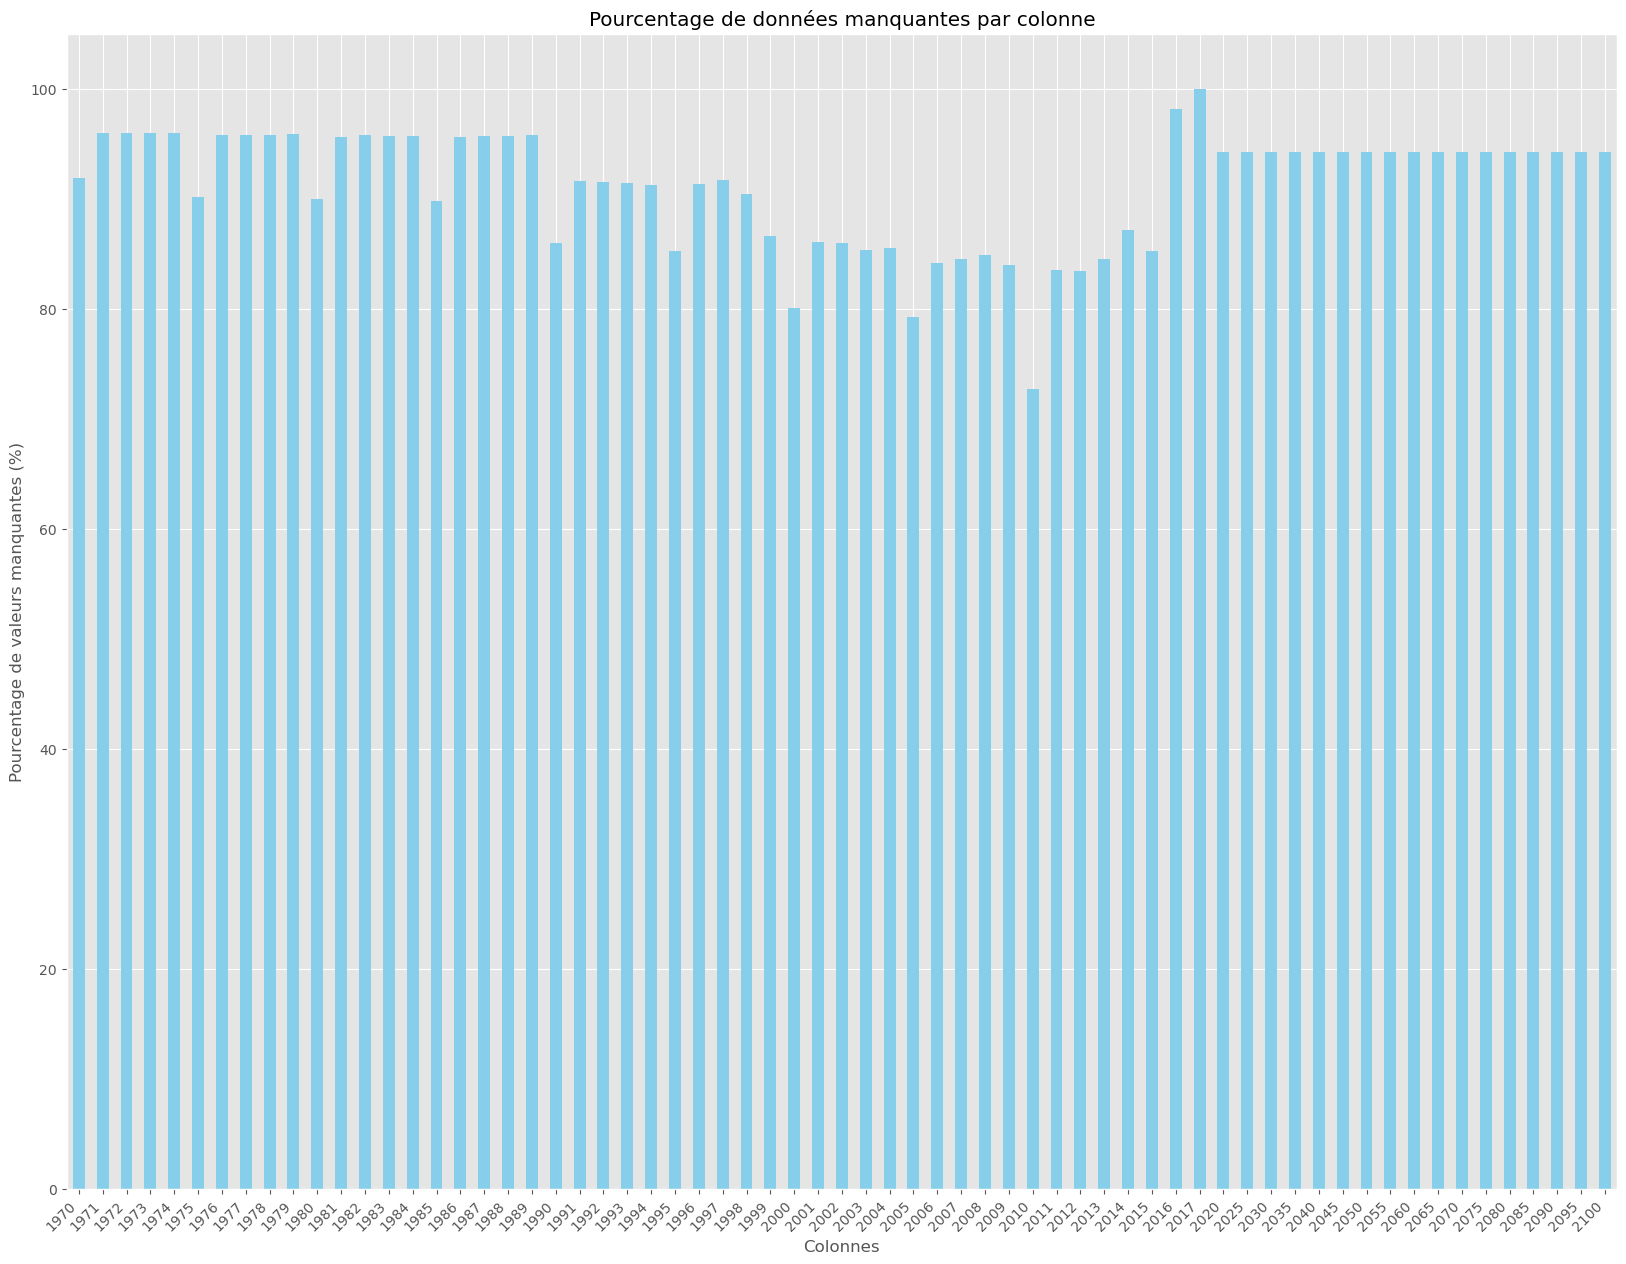

In [282]:
# Creation d'un graphique du pourcentage de données manquantes par colonnes
plt.figure(figsize=(20, 15))
pourcentage_manquantes.plot(kind='bar', color='skyblue')
plt.xlabel('Colonnes')
plt.ylabel('Pourcentage de valeurs manquantes (%)')
plt.title('Pourcentage de données manquantes par colonne')
plt.xticks(rotation=45, ha='right')
plt.show()

Bilan de ce fichier :
- Le fichier dispode de 886930 lignes et 70 colonnes
- Enormément de données manquantes
- Absence de doublons
- La variable Unnamed: 69 est vide
- Les données qui semblent etre le plus pertinentes à exploiter se situent entre 2000 et 2015 (avec entre 15 et 25 % de données exploitables)
- A partir de 2020 ce ne sont que des prédictions donc peu d'interet dans notre étude

### *2-4 EdStatsFootNote*

In [285]:
# Chargement + affichage de la base de données
data4 = pd.read_csv('EdStatsFootNote.csv')
data4.head(1)

,CountryCode,SeriesCode,Year,DESCRIPTION,Unnamed: 4
0,ABW,SE.PRE.ENRL.FE,YR2001,Country estimation.,NaN


In [286]:
# Affiche le nombre de lignes et de colonnes
data4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 643638 entries, 0 to 643637
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   CountryCode  643638 non-null  object 
 1   SeriesCode   643638 non-null  object 
 2   Year         643638 non-null  object 
 3   DESCRIPTION  643638 non-null  object 
 4   Unnamed: 4   0 non-null       float64
dtypes: float64(1), object(4)
memory usage: 24.6+ MB


Le fichier est composé de 643638 lignes et 5 colonnes.

In [287]:
# Recherche de données manquantes :
pd.DataFrame(data4.isnull().sum()).transpose()

,CountryCode,SeriesCode,Year,DESCRIPTION,Unnamed: 4
0,0,0,0,0,643638


In [288]:
# Recherche de doublons
data4.duplicated().sum()

0

In [289]:
# Recherche de doublons en prenant en compte toutes les colonnes
doublon_data4 = data4[data4.duplicated(['CountryCode','SeriesCode','Year','DESCRIPTION'], keep=False)].shape[0];
doublon_data4

0

In [290]:
# Recherche de doublons sur la colonnes Unnamed: 4
doublon_Unnamed4 = data4[data4.duplicated(['Unnamed: 4'], keep=False)].shape[0];
doublon_Unnamed4

643638

In [291]:
# On compte le nombre de pays par 'SeriesCode'
SeriesCode_distribution4 = data4['SeriesCode'].value_counts()
# On compte le nombre de pays par 'DESCRIPTION'
DESCRIPTION_distribution4 = data4['DESCRIPTION'].value_counts()
# On compte le nombre de pays par 'Year'
Year_distribution4 = data4['Year'].value_counts()
# Regroupe data4 par la colonne 'SeriesCode' et compte le nombre de lignes pour chaque SeriesCode.
stats_by_SeriesCode4 = data4.groupby('SeriesCode').size()
# Regroupe data4 par la colonne 'DESCRIPTION' et compte le nombre de lignes pour chaque Description.
stats_by_DESCRIPTION4 = data4.groupby('DESCRIPTION').size()
# Regroupe data4 par la colonne 'Year' et compte le nombre de lignes pour chaque années.
stats_by_Year4 = data4.groupby('Year').size()

In [292]:
# Identifier les 5 SeriesCode qui couvrent le plus grand nombre de pays 
nombre_pays_par_SeriesCode_unique4 = data4.groupby('SeriesCode')['CountryCode'].nunique().head(20)

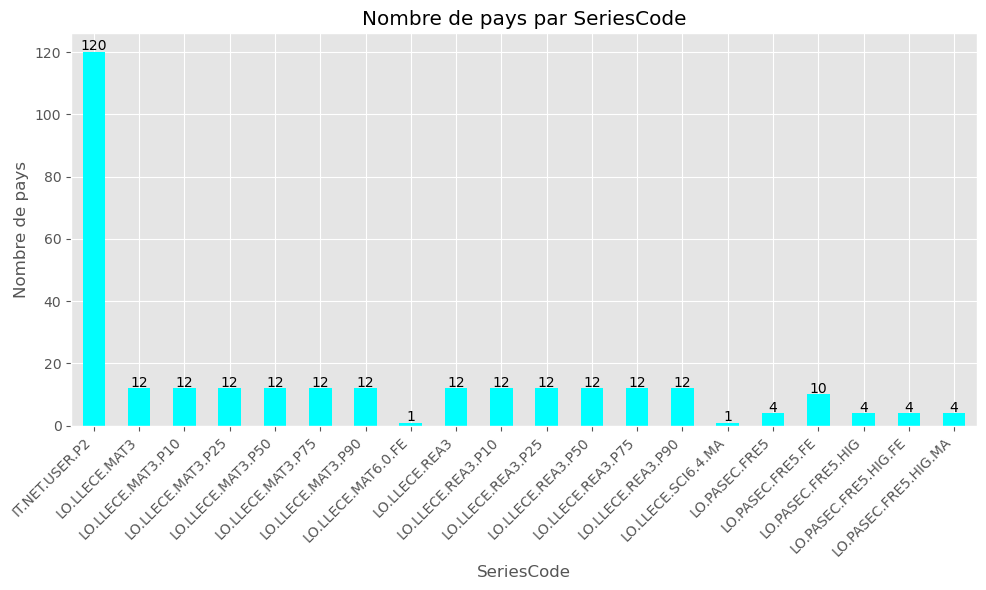

In [293]:
# Graphique du nombre de pays par SeriesCode
plt.figure(figsize=(10,6))
ax= nombre_pays_par_SeriesCode_unique4.plot(kind='bar', color='cyan')
plt.title('Nombre de pays par SeriesCode')
plt.ylabel('Nombre de pays')
plt.xlabel('SeriesCode')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
for index, value in enumerate(nombre_pays_par_SeriesCode_unique4):
    ax.text(index, value + 0.5, str(value), ha='center')
plt.show()

In [294]:
# Identifier les 5 DESCRIPTION qui couvrent le plus grand nombre de pays 
nombre_pays_par_DESCRIPTION_unique4 = data4.groupby('DESCRIPTION')['CountryCode'].nunique().sort_values(ascending=False).head(20)

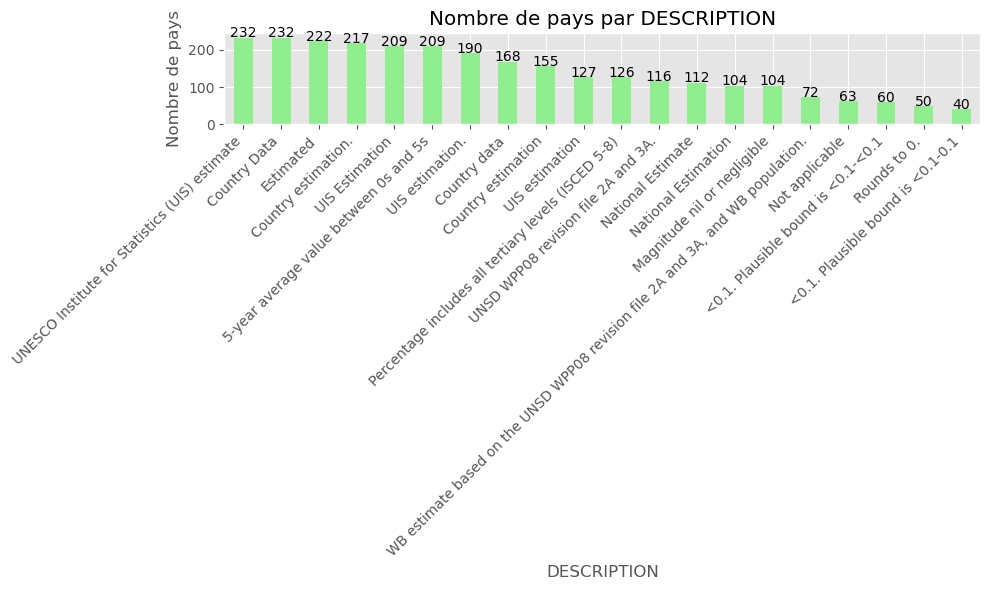

In [295]:
# Graphique du nombre de pays par DESCRIPTION
plt.figure(figsize=(10,6))
ax= nombre_pays_par_DESCRIPTION_unique4.plot(kind='bar', color='lightgreen')
plt.title('Nombre de pays par DESCRIPTION')
plt.ylabel('Nombre de pays')
plt.xlabel('DESCRIPTION')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
for index, value in enumerate(nombre_pays_par_DESCRIPTION_unique4):
    ax.text(index, value + 0.5, str(value), ha='center')
plt.show()

In [296]:
# Identifier les 5 Year qui couvrent le plus grand nombre de pays 
nombre_pays_par_Year_unique4 = data4.groupby('Year')['CountryCode'].nunique().sort_values(ascending=True).head(20)

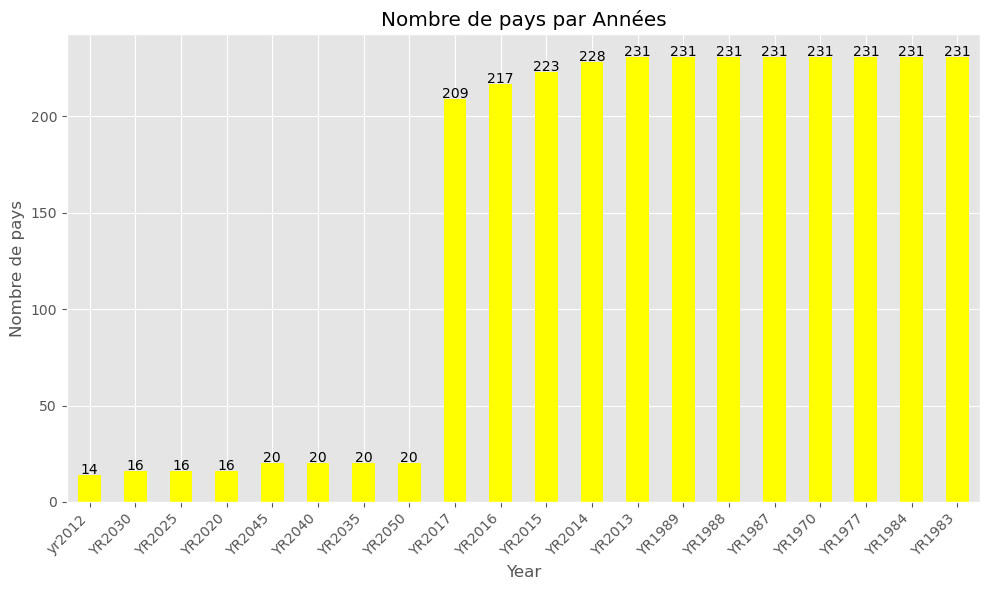

In [297]:
# Graphique du nombre de pays par Années
plt.figure(figsize=(10,6))
ax= nombre_pays_par_Year_unique4.plot(kind='bar', color='yellow')
plt.title('Nombre de pays par Années')
plt.ylabel('Nombre de pays')
plt.xlabel('Year')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
for index, value in enumerate(nombre_pays_par_Year_unique4):
    ax.text(index, value + 0.5, str(value), ha='center')
plt.show()

Bilan de ce fichier :
- Fichier qui ressemble énorément au fichier 2
- Il comporte 643638 lignes et 5 colonnes
- La fichier Unnamed : 4 est vide
- Sinon pas de données manquantes
- Et pas de doublons non plus
- Par rapport au fichier 2 seul l'année à été rajouter.
- Les années de 2020 à 2050 sont peu remplis en nombre de pays, comme l'année 2012

### *2-5 EdStatsSeries*

In [181]:
# Chargement + affichage de la base de données
data5 = pd.read_csv('EdStatsSeries.csv')
data5.head(1)

,Series Code,Topic,Indicator Name,Short definition,Long definition,Unit of measure,Periodicity,Base Period,Other notes,Aggregation method,Limitations and exceptions,Notes from original source,General comments,Source,Statistical concept and methodology,Development relevance,Related source links,Other web links,Related indicators,License Type,Unnamed: 20
0,BAR.NOED.1519.FE.ZS,Attainment,Barro-Lee: Percentage of female population age 15-19 with no education,Percentage of female population age 15-19 with no education,Percentage of female population age 15-19 with no education,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Robert J. Barro and Jong-Wha Lee: http://www.barrolee.com/,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [301]:
# Affiche le nombre de lignes et de colonnes
data5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3665 entries, 0 to 3664
Data columns (total 21 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Series Code                          3665 non-null   object 
 1   Topic                                3665 non-null   object 
 2   Indicator Name                       3665 non-null   object 
 3   Short definition                     2156 non-null   object 
 4   Long definition                      3665 non-null   object 
 5   Unit of measure                      0 non-null      float64
 6   Periodicity                          99 non-null     object 
 7   Base Period                          314 non-null    object 
 8   Other notes                          552 non-null    object 
 9   Aggregation method                   47 non-null     object 
 10  Limitations and exceptions           14 non-null     object 
 11  Notes from original source    

Le fichier contient 3665 lignes pour 21 colonnes.

In [302]:
# Recherche de données manquantes :
pd.DataFrame(data5.isnull().sum()).transpose()

,Series Code,Topic,Indicator Name,Short definition,Long definition,Unit of measure,Periodicity,Base Period,Other notes,Aggregation method,Limitations and exceptions,Notes from original source,General comments,Source,Statistical concept and methodology,Development relevance,Related source links,Other web links,Related indicators,License Type,Unnamed: 20
0,0,0,0,1509,0,3665,3566,3351,3113,3618,3651,3665,3651,0,3642,3662,3450,3665,3665,3665,3665


In [303]:
# Recherche de doublons
data5.duplicated().sum()

0

In [304]:
# Identifier les 5 descriptions qui couvrent le plus grand nombre de Topic
nombre_pays_par_TOPIC_unique = data5.groupby('Topic')['Series Code'].nunique().sort_values(ascending=False).head(5)

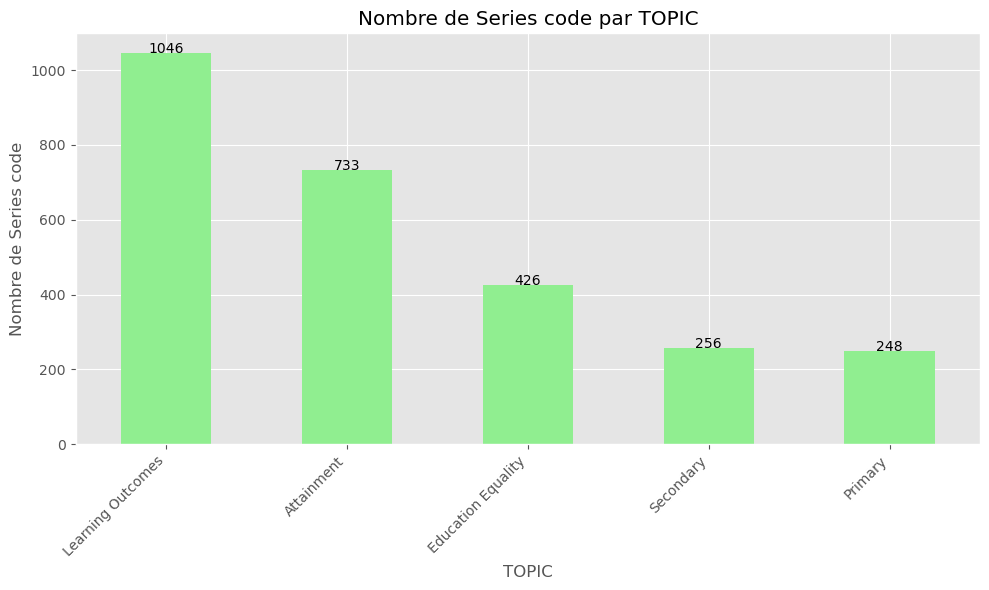

In [305]:
# Graphique du nombre de pays par DESCRIPTION
plt.figure(figsize=(10,6))
ax= nombre_pays_par_TOPIC_unique.plot(kind='bar', color='lightgreen')
plt.title('Nombre de Series code par TOPIC')
plt.ylabel('Nombre de Series code')
plt.xlabel('TOPIC')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
for index, value in enumerate(nombre_pays_par_TOPIC_unique):
    ax.text(index, value + 0.5, str(value), ha='center')
plt.show()

Bilan de ce fichier :
- Le fichier possède 3665 lignes et 21 colonnes
- Aucun doublon à signaler
- Enormément de données manquantes pour la plupart des variables
- Certaines variables sont complètement vide

### *2-6 Bilan*

Au vu des différents fichiers proposé seuls 3 permetteront de répondre à notre problématique :
- EdStatsCountry.csv qui nous mets en avant les pays,les régions et leur moyens
- EdStatsData.csv qui nous apporte les données necessaires
- EdStatsSeries.csv qui nous apporte des indicateur interessants
Les variables suivants seront retenus :
- "Long Name", "Region", "Income Groupe" (EdStatsCountry.csv)
- Les variables de 2010 à 2015 (EdStatsData.csv)
- "Indicator Code" qui devra être filtrés pour plus de précision

## **3/ Sélection des indicateurs pertinents**

Maintenant que nos bases de données sont nettoyer, essayons de garder les meilleurs paramètres afin de répondre à notre problématique.

### *3-1 Selection des indicateurs*

Dans le fichier EdStatsData on peut remarquer la présences de la colonne Series Code qu'on retrouve dans ce fichier 5. Cela va nous permettre de déterminer quelles sont les indicateurs qui permetteront de répondre au mieux à notre problématique.

In [184]:
# Creation d'un dataframe avec les colonnes les plus pertinentes
df5 = pd.DataFrame(data5,columns=["Series Code","Topic","Indicator Name","Long definition"])
df5.head(1)

,Series Code,Topic,Indicator Name,Long definition
0,BAR.NOED.1519.FE.ZS,Attainment,Barro-Lee: Percentage of female population age 15-19 with no education,Percentage of female population age 15-19 with no education


A partir du nom de l'indicateur on recherche des mots clefs qui pourront nous permettre de trier les indicateurs. Interressons nous à 4 points :
- Educatif
- Economique
- Numerique
- Population

Commençons par l'éducatif. Notre cible sont les lycéens et les étudiants. Ciblons donc SEC pour secondaire et TER pour tertiaire

In [188]:
# Définir le mot à rechercher
mot_cle = "SEC"
# Vérifier si le mot est présent dans la colonne 'SeriesCode'
presence_mot = data5['Series Code'].str.contains(mot_cle, case=False, na=False)
# Afficher les lignes où le mot est présent
lignes_avec_mot = data5[presence_mot]
lignes_avec_mot['Series Code'].head(3)

180    BAR.SEC.CMPT.1519.FE.ZS
181       BAR.SEC.CMPT.1519.ZS
182    BAR.SEC.CMPT.15UP.FE.ZS
Name: Series Code, dtype: object

In [190]:
# Affichage des Series Code et Indicator Name
colonnes_a_afficher = lignes_avec_mot[['Series Code', 'Indicator Name']]
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
display(colonnes_a_afficher)

,Series Code,Indicator Name
180,BAR.SEC.CMPT.1519.FE.ZS,Barro-Lee: Percentage of female population age 15-19 with secondary schooling. Completed Secondary
181,BAR.SEC.CMPT.1519.ZS,Barro-Lee: Percentage of population age 15-19 with secondary schooling. Completed Secondary
182,BAR.SEC.CMPT.15UP.FE.ZS,Barro-Lee: Percentage of female population age 15+ with secondary schooling. Completed Secondary
183,BAR.SEC.CMPT.15UP.ZS,Barro-Lee: Percentage of population age 15+ with secondary schooling. Completed Secondary
184,BAR.SEC.CMPT.2024.FE.ZS,Barro-Lee: Percentage of female population age 20-24 with secondary schooling. Completed Secondary
185,BAR.SEC.CMPT.2024.ZS,Barro-Lee: Percentage of population age 20-24 with secondary schooling. Completed Secondary
186,BAR.SEC.CMPT.2529.FE.ZS,Barro-Lee: Percentage of female population age 25-29 with secondary schooling. Completed Secondary
187,BAR.SEC.CMPT.2529.ZS,Barro-Lee: Percentage of population age 25-29 with secondary schooling. Completed Secondary
188,BAR.SEC.CMPT.25UP.FE.ZS,Barro-Lee: Percentage of female population age 25+ with secondary schooling. Completed Secondary
189,BAR.SEC.CMPT.25UP.ZS,Barro-Lee: Percentage of population age 25+ with secondary schooling. Completed Secondary


On repère ici beaucoup d'indicateurs. En éliminant les barro-lee et PASEC, on élimine une grande partie des indicateur. SE.SEC.ENRR est l'indicateur que l'on va conserver

In [193]:
# Définir le mot à rechercher
mot_cle2 = "TER"

# Vérifier si le mot est présent dans la colonne 'SeriesCode'
presence_mot2 = data5['Series Code'].str.contains(mot_cle2, case=False, na=False)

# Afficher les lignes où le mot est présent
lignes_avec_mot2 = data5[presence_mot2]

lignes_avec_mot2['Series Code'].head(3)

270    BAR.TER.CMPT.1519.FE.ZS
271       BAR.TER.CMPT.1519.ZS
272    BAR.TER.CMPT.15UP.FE.ZS
Name: Series Code, dtype: object

In [195]:
# Affichage des Series Code et Indicator Name
colonnes_a_afficher2 = lignes_avec_mot2[['Series Code', 'Indicator Name']]
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
display(colonnes_a_afficher2)

,Series Code,Indicator Name
270,BAR.TER.CMPT.1519.FE.ZS,Barro-Lee: Percentage of female population age 15-19 with tertiary schooling. Completed Tertiary
271,BAR.TER.CMPT.1519.ZS,Barro-Lee: Percentage of population age 15-19 with tertiary schooling. Completed Tertiary
272,BAR.TER.CMPT.15UP.FE.ZS,Barro-Lee: Percentage of female population age 15+ with tertiary schooling. Completed Tertiary
273,BAR.TER.CMPT.15UP.ZS,Barro-Lee: Percentage of population age 15+ with tertiary schooling. Completed Tertiary
274,BAR.TER.CMPT.2024.FE.ZS,Barro-Lee: Percentage of female population age 20-24 with tertiary schooling. Completed Tertiary
275,BAR.TER.CMPT.2024.ZS,Barro-Lee: Percentage of population age 20-24 with tertiary schooling. Completed Tertiary
276,BAR.TER.CMPT.2529.FE.ZS,Barro-Lee: Percentage of female population age 25-29 with tertiary schooling. Completed Tertiary
277,BAR.TER.CMPT.2529.ZS,Barro-Lee: Percentage of population age 25-29 with tertiary schooling. Completed Tertiary
278,BAR.TER.CMPT.25UP.FE.ZS,Barro-Lee: Percentage of female population age 25+ with tertiary schooling. Completed Tertiary
279,BAR.TER.CMPT.25UP.ZS,Barro-Lee: Percentage of population age 25+ with tertiary schooling. Completed Tertiary


On repère ici beaucoup d'indicateurs. En éliminant les barro-lee et SABER, on élimine une grande partie des indicateur. SE.TER.ENRR est l'indicateur que l'on va conserver qui est l'equivalent de celui garder plus tot mais dans le tertiaire cette fois

A présent occupons nous de l'aspect économique. Notre mots clefs sera GDP. Cherchons si un indicateur interéssants peut apparaitre

In [199]:
# Définir le mot à rechercher
mot_cle3 = "GDP"
# Vérifier si le mot est présent dans la colonne 'SeriesCode'
presence_mot3 = data5['Series Code'].str.contains(mot_cle3, case=False, na=False)
# Afficher les lignes où le mot est présent
lignes_avec_mot3 = data5[presence_mot3]
lignes_avec_mot3['Series Code'].head(3)

1658       NY.GDP.MKTP.CD
1659       NY.GDP.MKTP.KD
1660    NY.GDP.MKTP.PP.CD
Name: Series Code, dtype: object

In [201]:
# Affichage des Series Code et Indicator Name
colonnes_a_afficher3 = lignes_avec_mot3[['Series Code', 'Indicator Name']]
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
display(colonnes_a_afficher3)

,Series Code,Indicator Name
1658,NY.GDP.MKTP.CD,GDP (current US$)
1659,NY.GDP.MKTP.KD,GDP (constant 2010 US$)
1660,NY.GDP.MKTP.PP.CD,"GDP, PPP (current international $)"
1661,NY.GDP.MKTP.PP.KD,"GDP, PPP (constant 2011 international $)"
1662,NY.GDP.PCAP.CD,GDP per capita (current US$)
1663,NY.GDP.PCAP.KD,GDP per capita (constant 2010 US$)
1664,NY.GDP.PCAP.PP.CD,"GDP per capita, PPP (current international $)"
1665,NY.GDP.PCAP.PP.KD,"GDP per capita, PPP (constant 2011 international $)"
3581,UIS.XGDP.0.FSGOV,Government expenditure on pre-primary education as % of GDP (%)
3582,UIS.XGDP.0.FSgov.FDinstadm.FFd,Government expenditure in pre-primary institutions as % of GDP (%)


Beaucoup moins d'indicateurs cette fois. 4 semblent les plus intéréssants avec UIS.XGDP.23.FSGOV UIS.XGDP.56.FSGOV, NY.GDP.PCAP.CD et NY.GDP.MKTP.CD

Place maintenant à la population. Notre mot clef sera POP.

In [205]:
# Définir le mot à rechercher
mot_cle4 = "POP"
# Vérifier si le mot est présent dans la colonne 'SeriesCode'
presence_mot4 = data5['Series Code'].str.contains(mot_cle4, case=False, na=False)
# Afficher les lignes où le mot est présent
lignes_avec_mot4 = data5[presence_mot4]
lignes_avec_mot4['Series Code'].head(3)

30       BAR.POP.1519
31    BAR.POP.1519.FE
32       BAR.POP.15UP
Name: Series Code, dtype: object

In [207]:
# Affichage des Series Code et Indicator Name
colonnes_a_afficher4 = lignes_avec_mot4[['Series Code', 'Indicator Name']]
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
display(colonnes_a_afficher4)

,Series Code,Indicator Name
30,BAR.POP.1519,"Barro-Lee: Population in thousands, age 15-19, total"
31,BAR.POP.1519.FE,"Barro-Lee: Population in thousands, age 15-19, female"
32,BAR.POP.15UP,"Barro-Lee: Population in thousands, age 15+, total"
33,BAR.POP.15UP.FE,"Barro-Lee: Population in thousands, age 15+, female"
34,BAR.POP.2024,"Barro-Lee: Population in thousands, age 20-24, total"
35,BAR.POP.2024.FE,"Barro-Lee: Population in thousands, age 20-24, female"
36,BAR.POP.2529,"Barro-Lee: Population in thousands, age 25-29, total"
37,BAR.POP.2529.FE,"Barro-Lee: Population in thousands, age 25-29, female"
38,BAR.POP.25UP,"Barro-Lee: Population in thousands, age 25+, total"
39,BAR.POP.25UP.FE,"Barro-Lee: Population in thousands, age 25+, female"


Notre regard se dirige naturellement vers SP.POP.1524.TO.UN et SP.POP.1564.TO

Enfin pour finir le numérique. Notre mot cle sera IT.

In [211]:
# Définir le mot à rechercher
mot_cle5 = "IT"
# Vérifier si le mot est présent dans la colonne 'SeriesCode'
presence_mot5 = data5['Series Code'].str.contains(mot_cle5, case=False, na=False)
# Afficher les lignes où le mot est présent
lignes_avec_mot5 = data5[presence_mot5]
lignes_avec_mot5.head(3)

,Series Code,Topic,Indicator Name,Short definition,Long definition,Unit of measure,Periodicity,Base Period,Other notes,Aggregation method,Limitations and exceptions,Notes from original source,General comments,Source,Statistical concept and methodology,Development relevance,Related source links,Other web links,Related indicators,License Type,Unnamed: 20
610,IT.CMP.PCMP.P2,Infrastructure: Communications,Personal computers (per 100 people),NaN,Personal computers are self-contained computers designed to be used by a single individual.,NaN,Annual,NaN,NaN,Weighted average,NaN,NaN,Restricted use: Please cite the International Telecommunication Union for third-party use of these data. This indicator is not available in the World Development Indicators time series database.,"International Telecommunication Union, World Telecommunication/ICT Development Report and database.",NaN,NaN,NaN,NaN,NaN,NaN,NaN
611,IT.NET.USER.P2,Infrastructure: Communications,Internet users (per 100 people),NaN,"Internet users are individuals who have used the Internet (from any location) in the last 3 months. The Internet can be used via a computer, mobile phone, personal digital assistant, games machine, digital TV etc.",NaN,Annual,NaN,NaN,Weighted average,"Operators have traditionally been the main source of telecommunications data, so information on subscriptions has been widely available for most countries. This gives a general idea of access, but a more precise measure is the penetration rate - the share of households with access to telecommunications. During the past few years more information on information and communication technology use has become available from household and business surveys. Also important are data on actual use of telecommunications services. Ideally, statistics on telecommunications (and other information and communications technologies) should be compiled for all three measures: subscriptions, access, and use. The quality of data varies among reporting countries as a result of differences in regulations covering data provision and availability.\n\nDiscrepancies may also arise in cases where the end of a fiscal year differs from that used by ITU, which is the end of December of every year. A number of countries have fiscal years that end in March or June of every year.",NaN,Please cite the International Telecommunication Union for third-party use of these data.,"International Telecommunication Union, World Telecommunication/ICT Development Report and database.",NaN,NaN,NaN,NaN,NaN,NaN,NaN
746,LO.EGRA.INIT.0.BMN.2GRD,Learning Outcomes,EGRA: Identification of the Initial Sound of a Spoken Word - Share of students with a zero score (%). Bamanankan. 2nd Grade,"Share of students who could not identify the initial sound of any word read aloud to the student by the assessor (%). For example, the assessors ask students questions like “What is the first sound in the word ‘map’?"" and record the number of initial letters the students could identify within one minute. This EGRA subtask is a test of phonemic awareness -- the ability to identify, separate, and manipulate sounds in words. Consult the EdData website and the specific country report for more information: www.eddataglobal.org.","Share of students who could not identify the initial sound of any word read aloud to the student by the assessor (%). For example, the assessors ask students questions like “What is the first sound in the word ‘map’?"" and record the number of initial letters the students could identify within one minute. This EGRA subtask is a test of phonemic awareness -- the ability to identify, separate, and manipulate sounds in words. Consult the EdData website and the specific country report for more information: www.eddataglobal.org.",NaN,NaN,NaN,EGRA,NaN,NaN,NaN,NaN,Early Grade Reading Assessment (EGRA): https://www.eddataglobal.org/reading/,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [213]:
# Affichage des Series Code et Indicator Name
colonnes_a_afficher5 = lignes_avec_mot5[['Series Code', 'Indicator Name']]
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
display(colonnes_a_afficher5)

,Series Code,Indicator Name
610,IT.CMP.PCMP.P2,Personal computers (per 100 people)
611,IT.NET.USER.P2,Internet users (per 100 people)
746,LO.EGRA.INIT.0.BMN.2GRD,EGRA: Identification of the Initial Sound of a Spoken Word - Share of students with a zero score (%). Bamanankan. 2nd Grade
747,LO.EGRA.INIT.0.BOM.2GRD,EGRA: Identification of the Initial Sound of a Spoken Word - Share of students with a zero score (%). Bomu. 2nd Grade
748,LO.EGRA.INIT.0.CHC.2GRD,EGRA: Identification of the Initial Sound of a Spoken Word - Share of students with a zero score (%). Chichewa. 2nd Grade
749,LO.EGRA.INIT.0.CHC.4GRD,EGRA: Identification of the Initial Sound of a Spoken Word - Share of students with a zero score (%). Chichewa. 4th Grade
750,LO.EGRA.INIT.0.ENG.2GRD,EGRA: Identification of the Initial Sound of a Spoken Word - Share of students with a zero score (%). English. 2nd Grade
751,LO.EGRA.INIT.0.ENG.3GRD,EGRA: Identification of the Initial Sound of a Spoken Word - Share of students with a zero score (%). English. 3rd Grade
752,LO.EGRA.INIT.0.ENG.4GRD,EGRA: Identification of the Initial Sound of a Spoken Word - Share of students with a zero score (%). English. 4th Grade
753,LO.EGRA.INIT.0.ENG.6GRD,EGRA: Identification of the Initial Sound of a Spoken Word - Share of students with a zero score (%). English. 6th Grade


IT.NET.USER.P2 est l'indicateur parfait pour notre problématique

A travers ces différentes recherches , 9 indicateurs seront retenus :
- 2506 	SP.POP.1524.TO.UN 	Population, ages 15-24, total
- 2294 	SE.SEC.ENRR 	Gross enrolment ratio, secondary, both sexes (%)
- 2332 	SE.TER.ENRR 	Gross enrolment ratio, tertiary, both sexes (%)
- 3585 	UIS.XGDP.23.FSGOV 	Government expenditure on secondary education as % of GDP (%)
- 3589 	UIS.XGDP.56.FSGOV 	Government expenditure on tertiary education as % of GDP (%)
- 611 	IT.NET.USER.P2 	Internet users (per 100 people)
- 2509 	SP.POP.1564.TO 	Population ages 15-64, total
- 1658  NY.GDP.MKTP.CD 	GDP (dollars)
- 1662 	NY.GDP.PCAP.CD 	GDP per capita (dollars)

### *3-2 Création du data frame*

Créons un nouveau dataframe qui ne prendra en compte uniquement les indicateurs que l'on souhaite garder.

In [219]:
# Création d'un dataframe avec les colonnes les plus pertinentes
colonnes_interessees = ['Country Name', 'Country Code', 'Indicator Code', 'Indicator Name'] + [str(year) for year in range(2010, 2016)]
data3_selection = data3[colonnes_interessees]
data3_selection.head(4)

,Country Name,Country Code,Indicator Code,Indicator Name,2010,2011,2012,2013,2014,2015
0,Arab World,ARB,UIS.NERA.2,"Adjusted net enrolment rate, lower secondary, both sexes (%)",NaN,NaN,NaN,NaN,NaN,NaN
1,Arab World,ARB,UIS.NERA.2.F,"Adjusted net enrolment rate, lower secondary, female (%)",NaN,NaN,NaN,NaN,NaN,NaN
2,Arab World,ARB,UIS.NERA.2.GPI,"Adjusted net enrolment rate, lower secondary, gender parity index (GPI)",NaN,NaN,NaN,NaN,NaN,NaN
3,Arab World,ARB,UIS.NERA.2.M,"Adjusted net enrolment rate, lower secondary, male (%)",NaN,NaN,NaN,NaN,NaN,NaN


In [221]:
# Création d'un masque pour identifier les lignes où les colonnes 2010 à 2015 sont toutes vides
mask_vide = data3_selection.loc[:, '2010':'2015'].isnull().all(axis=1)
# Supprimer les lignes où les colonnes de 2010 à 2015 sont vides
data3_selection = data3_selection[~mask_vide]

In [223]:
# Affiche le nombre de lignes
data3_selection.info()

<class 'pandas.core.frame.DataFrame'>
Index: 313442 entries, 4 to 886929
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Country Name    313442 non-null  object 
 1   Country Code    313442 non-null  object 
 2   Indicator Code  313442 non-null  object 
 3   Indicator Name  313442 non-null  object 
 4   2010            242442 non-null  float64
 5   2011            146012 non-null  float64
 6   2012            147264 non-null  float64
 7   2013            137509 non-null  float64
 8   2014            113789 non-null  float64
 9   2015            131058 non-null  float64
dtypes: float64(6), object(4)
memory usage: 26.3+ MB


In [225]:
# Définir la liste des indicateurs retenus
indicateurs_retenus2 = ['SP.POP.1524.TO.UN', 'SE.SEC.ENRR', 'SE.TER.ENRR','UIS.XGDP.23.FSGOV', 'UIS.XGDP.56.FSGOV','IT.NET.USER.P2','SP.POP.1564.TO','NY.GDP.MKTP.CD','NY.GDP.PCAP.CD']
# Création d'un masque pour ne garder que les lignes avec les indicateurs choisis
mask = data3_selection['Indicator Code'].isin(indicateurs_retenus2)
# Filtrer le DataFrame avec le masque
data3_selection = data3_selection[mask]

In [227]:
data3_selection.head(9)

,Country Name,Country Code,Indicator Code,Indicator Name,2010,2011,2012,2013,2014,2015
1243,Arab World,ARB,NY.GDP.MKTP.CD,GDP at market prices (current US$),2.097884e+12,2.487905e+12,2.744381e+12,2.853079e+12,NaN,NaN
1245,Arab World,ARB,NY.GDP.PCAP.CD,GDP per capita (current US$),6.032962e+03,7.005480e+03,7.571402e+03,7.715999e+03,NaN,NaN
1335,Arab World,ARB,SE.SEC.ENRR,"Gross enrolment ratio, secondary, both sexes (%)",6.805088e+01,7.069149e+01,7.171656e+01,7.027469e+01,7.073505e+01,NaN
1339,Arab World,ARB,SE.TER.ENRR,"Gross enrolment ratio, tertiary, both sexes (%)",2.476180e+01,2.427387e+01,2.577601e+01,2.733034e+01,2.817496e+01,NaN
1375,Arab World,ARB,IT.NET.USER.P2,Internet users (per 100 people),2.674725e+01,2.970776e+01,3.401422e+01,3.686860e+01,NaN,NaN
2486,Arab World,ARB,SP.POP.1564.TO,"Population, ages 15-64, total",2.176207e+08,2.231343e+08,2.284061e+08,2.334388e+08,NaN,NaN
4908,East Asia & Pacific,EAS,NY.GDP.MKTP.CD,GDP at market prices (current US$),1.693876e+13,1.963867e+13,2.101913e+13,2.126254e+13,2.190003e+13,2.176695e+13
4910,East Asia & Pacific,EAS,NY.GDP.PCAP.CD,GDP per capita (current US$),7.679834e+03,8.844823e+03,9.402723e+03,9.447701e+03,9.665056e+03,9.541871e+03
5000,East Asia & Pacific,EAS,SE.SEC.ENRR,"Gross enrolment ratio, secondary, both sexes (%)",8.150263e+01,8.432813e+01,8.633956e+01,8.886735e+01,8.793482e+01,NaN


Pour plus de précision dans notre travail , rajoutons les colonnes Région et Income group

In [230]:
# Ajout et fusion des colonnes 'Region', 'Income Group' et 'Country Code' au DataFrame à partir de 'data' 
data3_merge = data3_selection.merge(data[['Country Code', 'Region', 'Income Group']], left_on='Country Code', right_on='Country Code', how='left')

In [232]:
#Affiche la région de la 11ème ligne
data3_merge.Region[11]

nan

In [234]:
data3_merge['Region'].unique()

array([nan, 'South Asia', 'Europe & Central Asia',
       'Middle East & North Africa', 'East Asia & Pacific',
       'Sub-Saharan Africa', 'Latin America & Caribbean', 'North America'],
      dtype=object)

In [236]:
# Recherche des Regions vide
data3_merge[data3_merge['Region'].isna()]

,Country Name,Country Code,Indicator Code,Indicator Name,2010,2011,2012,2013,2014,2015,Region,Income Group
0,Arab World,ARB,NY.GDP.MKTP.CD,GDP at market prices (current US$),2.097884e+12,2.487905e+12,2.744381e+12,2.853079e+12,NaN,NaN,NaN,NaN
1,Arab World,ARB,NY.GDP.PCAP.CD,GDP per capita (current US$),6.032962e+03,7.005480e+03,7.571402e+03,7.715999e+03,NaN,NaN,NaN,NaN
2,Arab World,ARB,SE.SEC.ENRR,"Gross enrolment ratio, secondary, both sexes (%)",6.805088e+01,7.069149e+01,7.171656e+01,7.027469e+01,7.073505e+01,NaN,NaN,NaN
3,Arab World,ARB,SE.TER.ENRR,"Gross enrolment ratio, tertiary, both sexes (%)",2.476180e+01,2.427387e+01,2.577601e+01,2.733034e+01,2.817496e+01,NaN,NaN,NaN
4,Arab World,ARB,IT.NET.USER.P2,Internet users (per 100 people),2.674725e+01,2.970776e+01,3.401422e+01,3.686860e+01,NaN,NaN,NaN,NaN
5,Arab World,ARB,SP.POP.1564.TO,"Population, ages 15-64, total",2.176207e+08,2.231343e+08,2.284061e+08,2.334388e+08,NaN,NaN,NaN,NaN
6,East Asia & Pacific,EAS,NY.GDP.MKTP.CD,GDP at market prices (current US$),1.693876e+13,1.963867e+13,2.101913e+13,2.126254e+13,2.190003e+13,2.176695e+13,NaN,NaN
7,East Asia & Pacific,EAS,NY.GDP.PCAP.CD,GDP per capita (current US$),7.679834e+03,8.844823e+03,9.402723e+03,9.447701e+03,9.665056e+03,9.541871e+03,NaN,NaN
8,East Asia & Pacific,EAS,SE.SEC.ENRR,"Gross enrolment ratio, secondary, both sexes (%)",8.150263e+01,8.432813e+01,8.633956e+01,8.886735e+01,8.793482e+01,NaN,NaN,NaN
9,East Asia & Pacific,EAS,SE.TER.ENRR,"Gross enrolment ratio, tertiary, both sexes (%)",2.777983e+01,2.903097e+01,3.109249e+01,3.330796e+01,3.914772e+01,NaN,NaN,NaN


On constate que dans notre base de données dans la colonne country name , des appelations se font passé pour des pays. Supprimons les. On garderas cependant les iles vierge britanique, gibraltar et nauru qui eux sont de vrais pays.

In [239]:
# Liste des country code à supprimer
valeurs_a_supprimer = ["ARB", "EAS", "EAP","EMU","ECS","ECA","EUU","HPC","HIC","LCN","LAC","LDC","LMY","LIC","LMC","MEA","MNA","MIC","NAC","OED","SAS","SSF","SSA","UMC","WLD"]
# Création d'un masque pour identifier les lignes à conserver
masque_a_conserver = ~data3_merge['Country Code'].isin(valeurs_a_supprimer)
# Appliquer le masque pour filtrer le DataFrame
data3_merge = data3_merge[masque_a_conserver]

In [241]:
data3_merge.head(3)

,Country Name,Country Code,Indicator Code,Indicator Name,2010,2011,2012,2013,2014,2015,Region,Income Group
150,Afghanistan,AFG,NY.GDP.MKTP.CD,GDP at market prices (current US$),1.593680e+10,1.793024e+10,2.053654e+10,2.004633e+10,2.005019e+10,1.921556e+10,South Asia,Low income
151,Afghanistan,AFG,NY.GDP.PCAP.CD,GDP per capita (current US$),5.533003e+02,6.035370e+02,6.690091e+02,6.317450e+02,6.120697e+02,5.695779e+02,South Asia,Low income
152,Afghanistan,AFG,SE.SEC.ENRR,"Gross enrolment ratio, secondary, both sexes (%)",5.324683e+01,5.461618e+01,5.667734e+01,5.668866e+01,5.565616e+01,5.564441e+01,South Asia,Low income


In [243]:
# Attribution des valeurs de région et de groupe de revenu
data3_merge.loc[data3_merge['Country Name'] == 'Gibraltar', ['Region', 'Income Group']] = ['Europe & Central Asia', 'High income']
data3_merge.loc[data3_merge['Country Name'] == 'Îles Vierges britanniques', ['Region', 'Income Group']] = ['Latin America & Caribbean', 'High income']
data3_merge.loc[data3_merge['Country Name'] == 'Nauru', ['Region', 'Income Group']] = ['East Asia & Pacific', 'High income']

### *3-3 Bilan* 

Au cours de notre séléction , on retiendra 4 thèmes : Economique, Educatif, Numérique, Population 
6 indicateurs retenus : SP.POP.1524.TO.UN, SE.SEC.ENRR, SE.TER.ENRR, UIS.XGDP.23.FSGOV, UIS.XGDP.56.FSGOV, IT.NET.USER.P2
6 années avec les meilleurs taux de remplissage : 2010,2011,2012,2013,2014,2015
Nous disposons maintenant d'un dataframe avec les colonnes les plus pertinentes ainsi que les indicateurs les plus utiles pour répondre à notre problématique.
Maintenant que notre dataframe est nettoyer et cohérents, il est temps de l'analyser.

## **4/ Analyse du jeu de données**

### *4-1 Scoring du jeu de données*

In [249]:
# Calculer la moyenne des années 2010-2015 pour chaque pays et indicateur
data3_merge['Moyenne_2010_2015'] = data3_merge[['2010', '2011', '2012', '2013', '2014', '2015']].mean(axis=1)

In [251]:
# Fusionner toutes les années en une seule série pour chaque indicateur et calculer les statistiques globales
statistiques_globales = data3_merge.melt(id_vars=['Country Name', 'Indicator Code'],value_vars=['2010', '2011', '2012', '2013', '2014', '2015'],var_name='Année',value_name='Valeur').groupby('Indicator Code')['Valeur'].agg(['mean', 'median', 'std', 'var']).rename(columns={'mean': 'Moyenne_Globale', 'median': 'Mediane_Globale', 'std': 'Ecart_Type_Globale', 'var': 'Variance_Globale'})
statistiques_globales

,Moyenne_Globale,Mediane_Globale,Ecart_Type_Globale,Variance_Globale
Indicator Code,,,,
IT.NET.USER.P2,4.142983e+01,4.000000e+01,2.875420e+01,8.268038e+02
NY.GDP.MKTP.CD,3.675431e+11,2.553281e+10,1.450784e+12,2.104774e+24
NY.GDP.PCAP.CD,1.610425e+04,6.028226e+03,2.378400e+04,5.656786e+08
SE.SEC.ENRR,8.402430e+01,9.160192e+01,2.685043e+01,7.209458e+02
SE.TER.ENRR,4.134320e+01,3.972569e+01,2.743229e+01,7.525303e+02
SP.POP.1524.TO.UN,6.679533e+06,1.321399e+06,2.429500e+07,5.902468e+14
SP.POP.1564.TO,2.418651e+07,5.009858e+06,9.526865e+07,9.076116e+15
UIS.XGDP.23.FSGOV,1.594643e+00,1.596990e+00,7.393048e-01,5.465716e-01
UIS.XGDP.56.FSGOV,9.643599e-01,9.251750e-01,5.325591e-01,2.836192e-01


In [253]:
# Indicateurs clés à vérifier
indicateurs_cles = ['SP.POP.1524.TO.UN', 'SE.SEC.ENRR', 'SE.TER.ENRR', 'UIS.XGDP.23.FSGOV', 'UIS.XGDP.56.FSGOV', 'IT.NET.USER.P2', 'SP.POP.1564.TO', 'NY.GDP.MKTP.CD', 'NY.GDP.PCAP.CD']
# Grouper les données par pays et vérifier les indicateurs présents pour chaque pays
pays_avec_tous_les_indicateurs = data3_merge.groupby('Country Name')['Indicator Code'].nunique()
# Filtrer les pays qui ont les 9 indicateurs requis
pays_complets = pays_avec_tous_les_indicateurs[pays_avec_tous_les_indicateurs == len(indicateurs_cles)].index
# Filtrer les données initiales
data3_merge_filtre = data3_merge[data3_merge['Country Name'].isin(pays_complets)]
data3_merge_filtre.head(6)

,Country Name,Country Code,Indicator Code,Indicator Name,2010,2011,2012,2013,2014,2015,Region,Income Group,Moyenne_2010_2015
157,Albania,ALB,NY.GDP.MKTP.CD,GDP at market prices (current US$),1.192695e+10,1.289087e+10,1.231978e+10,1.277628e+10,1.322824e+10,1.133526e+10,Europe & Central Asia,Upper middle income,1.241290e+10
158,Albania,ALB,NY.GDP.PCAP.CD,GDP per capita (current US$),4.094359e+03,4.437178e+03,4.247614e+03,4.413082e+03,4.578667e+03,3.934895e+03,Europe & Central Asia,Upper middle income,4.284299e+03
159,Albania,ALB,UIS.XGDP.23.FSGOV,Government expenditure on secondary education as % of GDP (%),NaN,NaN,NaN,7.016400e-01,NaN,NaN,Europe & Central Asia,Upper middle income,7.016400e-01
160,Albania,ALB,UIS.XGDP.56.FSGOV,Government expenditure on tertiary education as % of GDP (%),NaN,NaN,NaN,7.758500e-01,NaN,NaN,Europe & Central Asia,Upper middle income,7.758500e-01
161,Albania,ALB,SE.SEC.ENRR,"Gross enrolment ratio, secondary, both sexes (%)",8.841164e+01,9.084835e+01,9.274147e+01,9.583157e+01,9.642609e+01,9.576549e+01,Europe & Central Asia,Upper middle income,9.333743e+01
162,Albania,ALB,SE.TER.ENRR,"Gross enrolment ratio, tertiary, both sexes (%)",4.454065e+01,4.967040e+01,5.856549e+01,6.254776e+01,6.270685e+01,5.810995e+01,Europe & Central Asia,Upper middle income,5.602352e+01


Certaine données sont vides. Essayons de les remplir à travers différentes méthodes.


In [256]:
# Créer une copie
data3_merge_filtre = data3_merge_filtre.copy()
# Remplacer les valeurs NaN des années 2010 à 2015 par la valeur de Moyenne_2010_2015
for year in ['2010', '2011', '2012', '2013', '2014', '2015']:data3_merge_filtre.loc[:, year] = data3_merge_filtre[year].fillna(data3_merge_filtre['Moyenne_2010_2015'])
data3_merge_filtre.head(6)

,Country Name,Country Code,Indicator Code,Indicator Name,2010,2011,2012,2013,2014,2015,Region,Income Group,Moyenne_2010_2015
157,Albania,ALB,NY.GDP.MKTP.CD,GDP at market prices (current US$),1.192695e+10,1.289087e+10,1.231978e+10,1.277628e+10,1.322824e+10,1.133526e+10,Europe & Central Asia,Upper middle income,1.241290e+10
158,Albania,ALB,NY.GDP.PCAP.CD,GDP per capita (current US$),4.094359e+03,4.437178e+03,4.247614e+03,4.413082e+03,4.578667e+03,3.934895e+03,Europe & Central Asia,Upper middle income,4.284299e+03
159,Albania,ALB,UIS.XGDP.23.FSGOV,Government expenditure on secondary education as % of GDP (%),7.016400e-01,7.016400e-01,7.016400e-01,7.016400e-01,7.016400e-01,7.016400e-01,Europe & Central Asia,Upper middle income,7.016400e-01
160,Albania,ALB,UIS.XGDP.56.FSGOV,Government expenditure on tertiary education as % of GDP (%),7.758500e-01,7.758500e-01,7.758500e-01,7.758500e-01,7.758500e-01,7.758500e-01,Europe & Central Asia,Upper middle income,7.758500e-01
161,Albania,ALB,SE.SEC.ENRR,"Gross enrolment ratio, secondary, both sexes (%)",8.841164e+01,9.084835e+01,9.274147e+01,9.583157e+01,9.642609e+01,9.576549e+01,Europe & Central Asia,Upper middle income,9.333743e+01
162,Albania,ALB,SE.TER.ENRR,"Gross enrolment ratio, tertiary, both sexes (%)",4.454065e+01,4.967040e+01,5.856549e+01,6.254776e+01,6.270685e+01,5.810995e+01,Europe & Central Asia,Upper middle income,5.602352e+01


In [258]:
# Création d'un DataFrame de travail avec les indicateurs sélectionnés
indicateurs_cols = ['SP.POP.1524.TO.UN', 'SE.SEC.ENRR', 'SE.TER.ENRR', 'UIS.XGDP.23.FSGOV', 'UIS.XGDP.56.FSGOV', 'IT.NET.USER.P2', 'SP.POP.1564.TO', 'NY.GDP.MKTP.CD', 'NY.GDP.PCAP.CD']
moyennes_pays = data3_merge_filtre.groupby(['Country Name', 'Indicator Code'])[['2010', '2011', '2012', '2013', '2014', '2015']].mean().mean(axis=1).unstack()
indicateurs_data = moyennes_pays[indicateurs_cols].copy()
# Appliquer la normalisation
scaler = StandardScaler()
indicateurs_normalises = scaler.fit_transform(indicateurs_data)
# Convertir les données normalisées en DataFrame
indicateurs_normalises_df = pd.DataFrame(indicateurs_normalises, columns=indicateurs_cols, index=moyennes_pays.index)
moyennes_pays[indicateurs_cols] = indicateurs_normalises_df
moyennes_pays.head(50)

Indicator Code,IT.NET.USER.P2,NY.GDP.MKTP.CD,NY.GDP.PCAP.CD,SE.SEC.ENRR,SE.TER.ENRR,SP.POP.1524.TO.UN,SP.POP.1564.TO,UIS.XGDP.23.FSGOV,UIS.XGDP.56.FSGOV
Country Name,,,,,,,,,
Albania,0.436711,-0.282256,-0.553208,0.412439,0.580310,-0.261668,-0.281323,-1.336100,-0.408107
Argentina,0.522314,0.015155,-0.152472,0.795835,1.380961,0.000379,0.017836,0.525878,0.042374
Armenia,-0.007676,-0.283332,-0.584472,0.249850,0.234148,-0.264679,-0.280929,-0.439904,-1.347369
Australia,1.320570,0.523716,2.251612,1.838649,1.617243,-0.164338,-0.121848,0.266192,0.539207
Austria,1.281196,-0.049980,1.638929,0.597780,1.275176,-0.244829,-0.236823,1.060343,1.444732
Bangladesh,-1.142727,-0.203217,-0.716997,-0.867660,-0.928763,1.126706,0.900325,-0.986798,-1.494868
Barbados,0.979868,-0.286772,0.037120,0.801910,0.990710,-0.284431,-0.302704,-0.112721,2.248080
Belgium,1.337716,0.000981,1.455994,1.831905,1.129898,-0.233788,-0.218091,1.512859,0.911489
Belize,-0.268043,-0.288511,-0.535044,-0.088683,-0.583775,-0.283386,-0.302435,1.215390,-0.624785


<Figure size 1000x600 with 0 Axes>

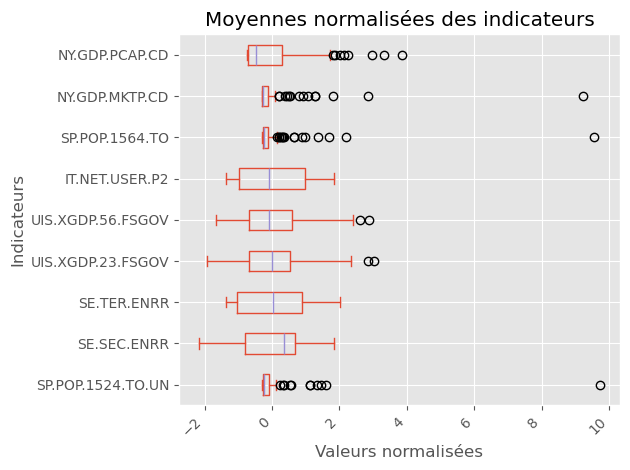

In [260]:
plt.figure(figsize=(10, 6))
indicateurs_normalises_df.plot(kind='box', vert=False)
plt.title("Moyennes normalisées des indicateurs")
plt.xlabel("Valeurs normalisées")
plt.ylabel("Indicateurs")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Comme prévu la moyenne de chaque indicateur est proche de 0. On peut cependant constater pour SP.POP.1524.TO.UN la présence d'une variable bien plus élevé que les autres.

In [263]:
moyennes_pays.describe()

Indicator Code,IT.NET.USER.P2,NY.GDP.MKTP.CD,NY.GDP.PCAP.CD,SE.SEC.ENRR,SE.TER.ENRR,SP.POP.1524.TO.UN,SP.POP.1564.TO,UIS.XGDP.23.FSGOV,UIS.XGDP.56.FSGOV
count,1.090000e+02,1.090000e+02,1.090000e+02,1.090000e+02,1.090000e+02,1.090000e+02,1.090000e+02,1.090000e+02,1.090000e+02
mean,4.074213e-18,-4.583490e-17,1.425975e-17,9.370690e-17,-2.220446e-16,7.562758e-17,3.463081e-17,3.381597e-16,-8.352137e-17
std,1.004619e+00,1.004619e+00,1.004619e+00,1.004619e+00,1.004619e+00,1.004619e+00,1.004619e+00,1.004619e+00,1.004619e+00
min,-1.358875e+00,-2.892692e-01,-7.500936e-01,-2.166802e+00,-1.375398e+00,-2.847770e-01,-3.037976e-01,-1.913839e+00,-1.661565e+00
25%,-9.716251e-01,-2.831095e-01,-6.989884e-01,-7.942835e-01,-1.035348e+00,-2.616430e-01,-2.788334e-01,-6.920250e-01,-6.700642e-01
50%,-9.963877e-02,-2.654107e-01,-4.824139e-01,3.515747e-01,2.333009e-02,-2.290314e-01,-2.319145e-01,1.144250e-02,-8.177187e-02
75%,9.640462e-01,-1.302873e-01,2.944573e-01,6.900881e-01,8.954838e-01,-8.180850e-02,-1.051491e-01,5.420991e-01,5.846260e-01
max,1.830931e+00,9.229232e+00,3.860681e+00,1.838649e+00,2.013055e+00,9.722972e+00,9.543997e+00,3.025607e+00,2.862095e+00


Interprétation : 
- count : chaque indicateur a 109 observations non manquantes
- mean : la moyenne est proche de 0 étant donnée que nos données ont été normalisé
- std : l'écart type est proche de 1 , des suites de la normalisation de nos données.
- min/max : pour SP.POP.1524.TO.UN la valeur maximale la plus élevée est 9,72 ce qui suggère que certaines observations de cet indicateur sont nettement plus importantes par rapport aux autres.

In [266]:
indicateurs = ['SP.POP.1524.TO.UN', 'SE.SEC.ENRR', 'SE.TER.ENRR', 'UIS.XGDP.23.FSGOV', 'UIS.XGDP.56.FSGOV', 'IT.NET.USER.P2', 'SP.POP.1564.TO', 'NY.GDP.MKTP.CD', 'NY.GDP.PCAP.CD']

# Calcul du Score Global
moyennes_pays['Score Global'] = moyennes_pays[indicateurs].sum(axis=1)

# Classement des pays selon le Score Global
classement_pays = moyennes_pays['Score Global'].sort_values(ascending=False)
classement_pays

Country Name
United States               19.272244
India                       17.648497
Denmark                     10.708513
Norway                      10.388053
Finland                      8.831049
Sweden                       8.216339
Netherlands                  8.177708
Germany                      8.174315
Australia                    8.071003
Belgium                      7.728963
New Zealand                  7.728327
United Kingdom               7.648513
France                       7.569519
Japan                        7.171531
Iceland                      6.819891
Austria                      6.766524
Switzerland                  6.701839
Ireland                      6.059612
Brazil                       5.713224
Spain                        5.643387
Malta                        4.928884
Korea, Rep.                  4.839612
Macao SAR, China             4.614659
Slovenia                     4.077612
Barbados                     4.071061
Italy                        3.912461

In [268]:
classement_pays.describe()

count    1.090000e+02
mean    -3.259370e-17
std      5.614434e+00
min     -9.619082e+00
25%     -4.535734e+00
50%     -6.433031e-01
75%      3.740585e+00
max      1.927224e+01
Name: Score Global, dtype: float64

Pour score globale :
- La moyenne est très proche de zéro, ce qui indique une distribution centrée autour de zéro.
- L'écart-type de 5,6 montre une certaine dispersion des scores entre les pays.
- Le maximum de 19,27 et le minimum de -9,61 montrent une grande variabilité des scores entre les pays.

In [271]:
# Convertir 'classement_pays' en DataFrame
classement_pays_df = classement_pays.reset_index()
classement_pays_df.columns = ['Country Name', 'Classement']

In [273]:
# Fusionner le classement avec 'data3_merge_filtre'
data3_merge_filtre = pd.merge(data3_merge_filtre, classement_pays_df, on='Country Name', how='left')
data3_merge_filtre.head(2)

,Country Name,Country Code,Indicator Code,Indicator Name,2010,2011,2012,2013,2014,2015,Region,Income Group,Moyenne_2010_2015,Classement
0,Albania,ALB,NY.GDP.MKTP.CD,GDP at market prices (current US$),1.192695e+10,1.289087e+10,1.231978e+10,1.277628e+10,1.322824e+10,1.133526e+10,Europe & Central Asia,Upper middle income,1.241290e+10,-1.693203
1,Albania,ALB,NY.GDP.PCAP.CD,GDP per capita (current US$),4.094359e+03,4.437178e+03,4.247614e+03,4.413082e+03,4.578667e+03,3.934895e+03,Europe & Central Asia,Upper middle income,4.284299e+03,-1.693203


In [275]:
# Calculer le score moyen par région en utilisant la nouvelle colonne 'Classement'
scoring_region = data3_merge_filtre.groupby('Region')['Classement'].mean()
# Classer les régions par score moyen décroissant
classement_regions = scoring_region.sort_values(ascending=False)

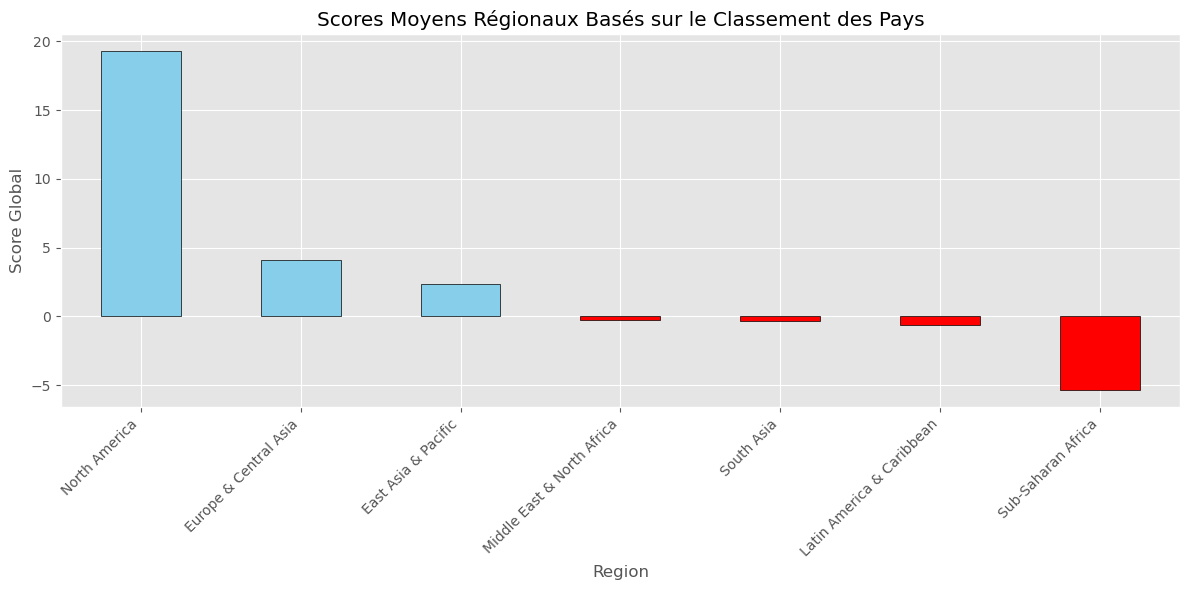

In [277]:
# Création d'un graphique
colors = ['red' if val < 0 else 'skyblue' for val in classement_regions]
plt.figure(figsize=(12, 6))
classement_regions.sort_values(ascending=False).plot(kind='bar', color=colors, edgecolor='black')
plt.title('Scores Moyens Régionaux Basés sur le Classement des Pays')
plt.xlabel('Region')
plt.ylabel('Score Global')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [279]:
# Calculer le score moyen par Income Group en utilisant la nouvelle colonne 'Classement'
scoring_Income_Group = data3_merge_filtre.groupby('Income Group')['Classement'].mean()

# Classer les Income Group par score moyen décroissant
classement_Income_Group = scoring_Income_Group.sort_values(ascending=False)

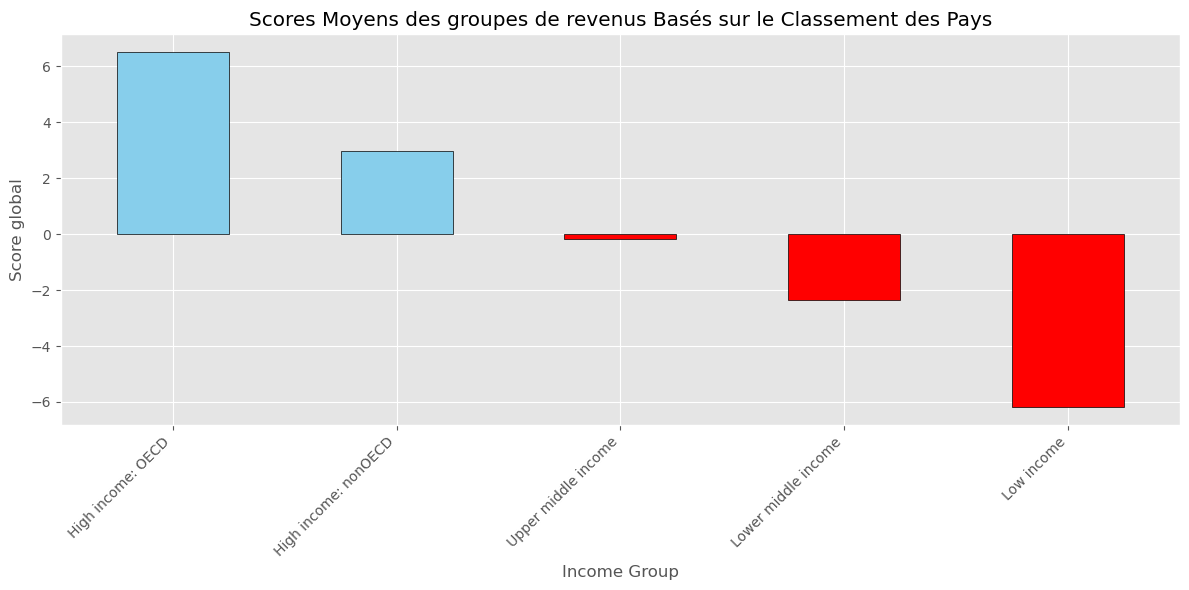

In [281]:
# Création d'un graphique
colors = ['red' if val < 0 else 'skyblue' for val in classement_Income_Group]
plt.figure(figsize=(12, 6))
classement_Income_Group.sort_values(ascending=False).plot(kind='bar', color=colors, edgecolor='black')
plt.title('Scores Moyens des groupes de revenus Basés sur le Classement des Pays')
plt.xlabel('Income Group')
plt.ylabel('Score global')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### 4-2 *Prédiction des données*

In [284]:
# Définir les années passées et futures
annees_passees = np.array([2010, 2011, 2012, 2013, 2014, 2015]).reshape(-1, 1)
annees_futures = np.array([2016, 2017, 2018, 2019, 2020]).reshape(-1, 1)
# Boucler sur chaque indicateur et chaque pays
for indicateur in ['SP.POP.1524.TO.UN', 'SE.SEC.ENRR', 'SE.TER.ENRR', 'UIS.XGDP.23.FSGOV', 'UIS.XGDP.56.FSGOV', 'IT.NET.USER.P2', 'SP.POP.1564.TO', 'NY.GDP.MKTP.CD', 'NY.GDP.PCAP.CD']:
    for pays in data3_merge_filtre['Country Name'].unique():
        # Filtrer les données pour le pays et l'indicateur
        subset = data3_merge_filtre[(data3_merge_filtre['Country Name'] == pays) & (data3_merge_filtre['Indicator Code'] == indicateur)]
        # Vérifier s'il y a des valeurs pour toutes les années de 2010 à 2015
        y = subset[['2010', '2011', '2012', '2013', '2014', '2015']].values.flatten()
        if np.isnan(y).any() or len(y) != len(annees_passees):
            continue  
        # Créer et entraîner le modèle de régression linéaire
        modele = LinearRegression()
        modele.fit(annees_passees, y)
        # Prédire les valeurs pour les années futures 
        predictions = modele.predict(annees_futures)
        # Ajouter les valeurs prédites directement dans le DataFrame
        for i, annee in enumerate(range(2016, 2020 + 1)):
            data3_merge_filtre.loc[(data3_merge_filtre['Country Name'] == pays) & (data3_merge_filtre['Indicator Code'] == indicateur), str(annee)] = predictions[i]

In [285]:
data3_merge_filtre['Moyenne_2016_2020'] = data3_merge_filtre[['2016', '2017', '2018', '2019', '2020']].mean(axis=1)

In [286]:
data3_merge_filtre.head(5)

,Country Name,Country Code,Indicator Code,Indicator Name,2010,2011,2012,2013,2014,2015,Region,Income Group,Moyenne_2010_2015,Classement,2016,2017,2018,2019,2020,Moyenne_2016_2020
0,Albania,ALB,NY.GDP.MKTP.CD,GDP at market prices (current US$),1.192695e+10,1.289087e+10,1.231978e+10,1.277628e+10,1.322824e+10,1.133526e+10,Europe & Central Asia,Upper middle income,1.241290e+10,-1.693203,1.226392e+10,1.222135e+10,1.217878e+10,1.213622e+10,1.209365e+10,1.217878e+10
1,Albania,ALB,NY.GDP.PCAP.CD,GDP per capita (current US$),4.094359e+03,4.437178e+03,4.247614e+03,4.413082e+03,4.578667e+03,3.934895e+03,Europe & Central Asia,Upper middle income,4.284299e+03,-1.693203,4.263561e+03,4.257636e+03,4.251710e+03,4.245785e+03,4.239860e+03,4.251710e+03
2,Albania,ALB,UIS.XGDP.23.FSGOV,Government expenditure on secondary education as % of GDP (%),7.016400e-01,7.016400e-01,7.016400e-01,7.016400e-01,7.016400e-01,7.016400e-01,Europe & Central Asia,Upper middle income,7.016400e-01,-1.693203,7.016400e-01,7.016400e-01,7.016400e-01,7.016400e-01,7.016400e-01,7.016400e-01
3,Albania,ALB,UIS.XGDP.56.FSGOV,Government expenditure on tertiary education as % of GDP (%),7.758500e-01,7.758500e-01,7.758500e-01,7.758500e-01,7.758500e-01,7.758500e-01,Europe & Central Asia,Upper middle income,7.758500e-01,-1.693203,7.758500e-01,7.758500e-01,7.758500e-01,7.758500e-01,7.758500e-01,7.758500e-01
4,Albania,ALB,SE.SEC.ENRR,"Gross enrolment ratio, secondary, both sexes (%)",8.841164e+01,9.084835e+01,9.274147e+01,9.583157e+01,9.642609e+01,9.576549e+01,Europe & Central Asia,Upper middle income,9.333743e+01,-1.693203,9.899669e+01,1.006136e+02,1.022306e+02,1.038475e+02,1.054644e+02,1.022306e+02


In [287]:
# Créer un DataFrame de travail avec les indicateurs sélectionnés
indicateurs_cols2 = ['SP.POP.1524.TO.UN', 'SE.SEC.ENRR', 'SE.TER.ENRR', 'UIS.XGDP.23.FSGOV', 'UIS.XGDP.56.FSGOV', 'IT.NET.USER.P2','SP.POP.1564.TO','NY.GDP.MKTP.CD','NY.GDP.PCAP.CD']
moyennes_pays2 = data3_merge_filtre.groupby(['Country Name', 'Indicator Code'])[['2016', '2017', '2018', '2019', '2020']].mean().mean(axis=1).unstack()
# Vérifier la présence des colonnes dans les données
indicateurs_data2 = moyennes_pays2[indicateurs_cols2].copy()
# Appliquer la normalisation Standard Scaling
scaler = StandardScaler()
indicateurs_normalises2 = scaler.fit_transform(indicateurs_data2)
# Convertir les données normalisées en DataFrame
indicateurs_normalises_df2 = pd.DataFrame(indicateurs_normalises2, columns=indicateurs_cols2, index=moyennes_pays2.index)
moyennes_pays2[indicateurs_cols2] = indicateurs_normalises_df2
moyennes_pays2.head(50)

Indicator Code,IT.NET.USER.P2,NY.GDP.MKTP.CD,NY.GDP.PCAP.CD,SE.SEC.ENRR,SE.TER.ENRR,SP.POP.1524.TO.UN,SP.POP.1564.TO,UIS.XGDP.23.FSGOV,UIS.XGDP.56.FSGOV
Country Name,,,,,,,,,
Albania,0.634464,-0.259134,-0.554348,0.382445,1.055885,-0.260157,-0.278336,-1.280872,-0.400107
Argentina,0.887620,0.061113,-0.071132,0.564998,1.448254,-0.002805,0.012514,0.759389,0.188124
Armenia,0.797190,-0.259055,-0.556405,-0.003556,-0.140099,-0.266361,-0.278387,-0.544661,-1.419423
Australia,1.148872,0.536324,2.251917,1.444488,1.687995,-0.164043,-0.122224,0.030500,0.596745
Austria,1.061776,-0.057773,1.435572,0.332696,1.655273,-0.243527,-0.236557,0.799136,1.625623
Bangladesh,-1.115332,-0.147564,-0.684206,-0.562307,-0.967679,1.125861,0.917316,-0.956777,-1.428313
Barbados,0.926397,-0.262892,-0.001209,0.599453,0.835983,-0.279887,-0.298570,-0.392838,2.950456
Belgium,1.171022,-0.022350,1.195797,3.691538,1.248698,-0.231889,-0.219618,1.460135,0.845905
Belize,-0.218081,-0.264238,-0.510027,-0.107806,-0.585524,-0.278482,-0.297906,0.929769,-0.381872


<Figure size 1000x600 with 0 Axes>

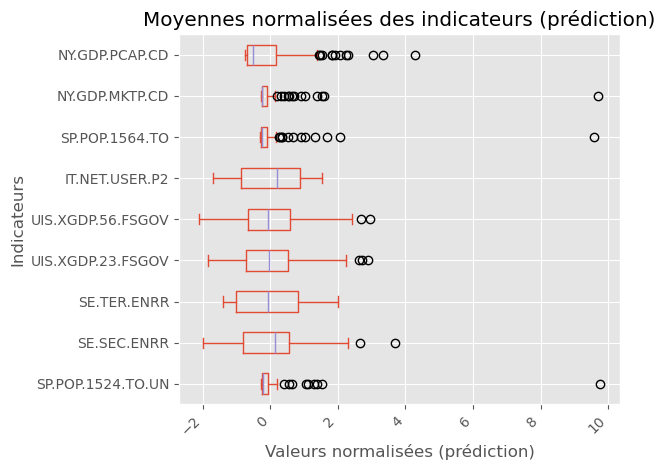

In [288]:
# Création d'un graphique
plt.figure(figsize=(10, 6))
indicateurs_normalises_df2.plot(kind='box', vert=False)
plt.title("Moyennes normalisées des indicateurs (prédiction)")
plt.xlabel("Valeurs normalisées (prédiction)")
plt.ylabel("Indicateurs")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [289]:
moyennes_pays2.describe()

Indicator Code,IT.NET.USER.P2,NY.GDP.MKTP.CD,NY.GDP.PCAP.CD,SE.SEC.ENRR,SE.TER.ENRR,SP.POP.1524.TO.UN,SP.POP.1564.TO,UIS.XGDP.23.FSGOV,UIS.XGDP.56.FSGOV
count,1.090000e+02,1.090000e+02,1.090000e+02,1.090000e+02,1.090000e+02,1.090000e+02,1.090000e+02,1.090000e+02,1.090000e+02
mean,-9.574400e-17,-6.569668e-17,3.972358e-17,-1.853767e-16,1.487088e-16,-3.081124e-17,-6.365958e-17,5.072395e-16,-1.079666e-16
std,1.004619e+00,1.004619e+00,1.004619e+00,1.004619e+00,1.004619e+00,1.004619e+00,1.004619e+00,1.004619e+00,1.004619e+00
min,-1.697010e+00,-2.650069e-01,-7.393074e-01,-1.999828e+00,-1.395237e+00,-2.801703e-01,-2.994079e-01,-1.834024e+00,-2.114068e+00
25%,-8.795003e-01,-2.591344e-01,-6.793372e-01,-8.049298e-01,-1.006345e+00,-2.601569e-01,-2.748300e-01,-7.332640e-01,-6.665018e-01
50%,2.014803e-01,-2.404116e-01,-5.100269e-01,1.381430e-01,-5.491304e-02,-2.224520e-01,-2.326766e-01,-4.781249e-02,-5.730127e-02
75%,8.876200e-01,-1.040663e-01,1.645675e-01,5.649984e-01,8.110850e-01,-6.610750e-02,-9.257326e-02,5.230736e-01,5.845195e-01
max,1.526195e+00,9.693201e+00,4.273620e+00,3.691538e+00,2.002537e+00,9.760334e+00,9.592930e+00,2.890360e+00,2.950456e+00


In [290]:
indicateurs = ['SP.POP.1524.TO.UN', 'SE.SEC.ENRR', 'SE.TER.ENRR', 'UIS.XGDP.23.FSGOV', 'UIS.XGDP.56.FSGOV', 
               'IT.NET.USER.P2', 'SP.POP.1564.TO', 'NY.GDP.MKTP.CD', 'NY.GDP.PCAP.CD']

# Calcul du Score Global 
moyennes_pays2['Score Global'] = moyennes_pays2[indicateurs].sum(axis=1)

# Classement des pays selon le Score Global
classement_pays2 = moyennes_pays2['Score Global'].sort_values(ascending=False)
classement_pays2

Country Name
India                       18.603853
United States               18.470886
Denmark                      9.984410
Belgium                      9.139238
Norway                       8.604048
United Kingdom               7.755295
Sweden                       7.729594
Australia                    7.410574
Finland                      7.247671
Netherlands                  7.054936
Germany                      6.930239
Ireland                      6.530511
Iceland                      6.377244
Austria                      6.372218
New Zealand                  6.323166
France                       6.281463
Switzerland                  6.247048
Macao SAR, China             6.219696
Brazil                       5.216616
Japan                        4.780379
Spain                        4.624324
Malta                        4.578398
Korea, Rep.                  4.243422
Barbados                     4.076893
Argentina                    3.848075
Cyprus                       3.787948

## **5/ Conclusion**

Au cours de notre projet nous avons analysé 5 bases de données. Après analyse nous en avons conservé 3. Une fois nettoyer nous avons sélectioner les variables et informations les plus pertinentes.
L'analyse des ces données ont montré qu'il y avait un top 10 de pays qui pouvait être intéressant. Les états unis, l'Inde, le Danemark, la Norvège, la Finlande, la Suède, les Pays-Bas, l'Allemagne, la Belgique, la Nouvelle Zélande. Cependant ces résultat sont évidemment à prendre avec des pincettes. L'Inde est certes première de notre classement mais c'est uniquement car sa population est conséquente. La présence de deux indicateurs population était impératif afin d'éliminer les petites iles avec peu d'habitants tels que les Bermudes.
Les régions les mieux notés l'Amérique du nord et l'Europe. Et les pays membre de L'OCDE sont les plus représenter.
Des prédictions ont été réalisé à l'aide d'une regression linéaire. Dans l'ordre l'Inde, les Etats-Unis, le Danemark, la Belgique, la Norvège, la Grande Bretagne, la Suède, l'Australie, la Finlande, les Pays-Bas.
Ainsi si je devais sélectionné 5 pays ou se dirigé , je conseillerais :
- Danemark
- Finlande
- Etats-Unis
- Belgique
- Norvège

Ces 5 pays sont soit en Amérique du Nord , soit en Europe et sont tous pays membres de l'Organisation de coopération et de développement économiques qui sont classés comme ayant un revenu élevé. Là où l'Inde à un revenu moyen par habitant qui se situe dans la partie inférieure de la catégorie des revenus intermédiaires et donc peut se présenter comme un choix  plus risqué.